In [4]:
'''
В данном ноутбуке постарался сохранить больше данных, а также применить новые методы обработки пустых значений + применил нелинейные модели
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_excel("data.xlsx")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112635 entries, 0 to 112634
Data columns (total 56 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ссылка                112635 non-null  object 
 1   до центра             106897 non-null  object 
 2   комнат                112635 non-null  object 
 3   Площадь квартиры      112583 non-null  object 
 4   Жилая площадь         90732 non-null   object 
 5   Этаж                  111822 non-null  float64
 6   Санузел               71990 non-null   object 
 7   Кол-во санузлов       90622 non-null   float64
 8   Ремонт                48258 non-null   object 
 9   Вид из окна           61723 non-null   object 
 10  Год постройки         20837 non-null   float64
 11  Высота потолков       83705 non-null   object 
 12  Лифт                  85074 non-null   object 
 13  Материал стен         95838 non-null   object 
 14  Парковка              60672 non-null   object 
 15  

In [9]:
# Удаляем столбцы, которые являются служебными или имеют очень низкое покрытие данных,
# и, следовательно, не влияют на предсказание стоимости квартиры.
#адрес и описание тяжело на данный момент обработать так, чтобы вытащить оттуда полезную информацию - уберем их из датасета
columns_to_drop = [
    'ссылка',
    'Source_File',
    'Sheet_Name',
    'Кондиционер',
    'Мебель',
    'Кухонная мебель',
    'Реновация',
    'Посудомойка',
    'Интернет',
    'Телевизор',
    'Холодильник',
    'Стиральная машина',
    'Консьерж',
    'адрес',
    'описание',
    
]

df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112635 entries, 0 to 112634
Data columns (total 41 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   до центра             106897 non-null  object 
 1   комнат                112635 non-null  object 
 2   Площадь квартиры      112583 non-null  object 
 3   Жилая площадь         90732 non-null   object 
 4   Этаж                  111822 non-null  float64
 5   Санузел               71990 non-null   object 
 6   Кол-во санузлов       90622 non-null   float64
 7   Ремонт                48258 non-null   object 
 8   Вид из окна           61723 non-null   object 
 9   Год постройки         20837 non-null   float64
 10  Высота потолков       83705 non-null   object 
 11  Лифт                  85074 non-null   object 
 12  Материал стен         95838 non-null   object 
 13  Парковка              60672 non-null   object 
 14  цена                  112635 non-null  object 
 15  

In [10]:
#удалим дубликаты
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88322 entries, 0 to 112634
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   до центра             83909 non-null  object 
 1   комнат                88322 non-null  object 
 2   Площадь квартиры      88306 non-null  object 
 3   Жилая площадь         70860 non-null  object 
 4   Этаж                  87933 non-null  float64
 5   Санузел               56621 non-null  object 
 6   Кол-во санузлов       70782 non-null  float64
 7   Ремонт                38459 non-null  object 
 8   Вид из окна           48004 non-null  object 
 9   Год постройки         17043 non-null  float64
 10  Высота потолков       65234 non-null  object 
 11  Лифт                  67019 non-null  object 
 12  Материал стен         75226 non-null  object 
 13  Парковка              47867 non-null  object 
 14  цена                  88322 non-null  object 
 15  станция1              8

In [11]:
df['Серия дома'].unique()

array([nan, '1-511', 'II-49', 'II-18', '1-515', '1605-АМ', 'П-3',
       '1-МГ-601', 'П-44Т', 'II-68', 'П-30', 'П-44', 'II-29', 'П-3М',
       '1-510', 'II-05', 'П-46м', 'Башня Вулыха', 'П-44К', 'II-57',
       'И-209А', 'П-46', 'П-111М', 'П-43', '137', '1-335', 'И-155',
       'И-700', 'ПД-4', 'II-18/12', 'И-522', 'П-47', 'К-7', 'КОПЭ',
       'И-491А', 'C-222', 'П-23', 'П-55', 'ГМС-2001', 'П-44/17',
       'КОПЭ-2000', 'II-67', 'П-55М', 'II-66', 'ИП-46С',
       'Башня Смирновская', 'П-42', 'Башня Москворецкая'], dtype=object)

In [12]:
#переводим в числовой формат все столбцы, которые можно перевести из object
def convert_to_numeric(df, threshold=0.7):
    """
    Преобразует столбцы DataFrame в числовой тип, если доля преобразованных значений среди непустых
    значений в столбце превышает порог threshold.
    """
    for col in df.columns:
        # Если столбец имеет тип object, то применяем замену запятых на точки
        if df[col].dtype == 'object':
            # Приводим к строке, затем заменяем запятые на точки
            converted_col = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
        else:
            converted_col = pd.to_numeric(df[col], errors='coerce')
        # Число ненулевых (не NaN) исходных значений
        non_missing = df[col].notna().sum()
        if non_missing == 0:
            # Если столбец полностью пустой, ничего не делаем
            continue
        # Доля успешно преобразованных значений (без учета исходных пропущенных значений)
        ratio = converted_col.notna().sum() / non_missing
        # if col=='Площадь кухни' or col=='Высота потолков' or col=='Жилая площадь' or col=='Площадь квартиры' or col=='до центра':
        #     print(ratio)
        #     print(df[col].unique())
        if ratio >= threshold: # Если доля преобразованных значений больше порога, заменяем столбец
            df[col] = converted_col

    return df

df_cleaned = convert_to_numeric(df_cleaned)
print(df_cleaned.dtypes)

до центра               float64
комнат                  float64
Площадь квартиры        float64
Жилая площадь           float64
Этаж                    float64
Санузел                  object
Кол-во санузлов         float64
Ремонт                   object
Вид из окна              object
Год постройки           float64
Высота потолков         float64
Лифт                     object
Материал стен            object
Парковка                 object
цена                    float64
станция1                 object
время_до_станции1       float64
пешком1                 float64
станция2                 object
время_до_станции2       float64
пешком2                 float64
станция3                 object
время_до_станции3       float64
пешком3                 float64
Этажей в доме           float64
Отделка                  object
Срок сдачи               object
Временная эпоха          object
Отопление                object
Тип жилья                object
Балкон/лоджия            object
Серия до

In [241]:
df_cleaned.describe(include='number')

до центра        комнат  Площадь квартиры  Жилая площадь  \
count  83909.000000  82921.000000      88294.000000   70859.000000   
mean      12.557311      1.864606         65.206774      33.772472   
std        7.185627      1.067980         53.161379      30.740168   
min        0.000000      0.000000          8.000000       1.000000   
25%        7.200000      1.000000         37.900000      18.000000   
50%       12.000000      2.000000         53.100000      27.500000   
75%       16.400000      3.000000         73.500000      40.600000   
max       30.000000      4.000000        993.600000     832.000000   

               Этаж  Кол-во санузлов  Год постройки  Высота потолков  \
count  87933.000000     70782.000000   17043.000000     65234.000000   
mean      11.020106         1.321084    2020.054274         3.198968   
std        9.396640         0.657399       4.847497         8.504692   
min       -1.000000         1.000000    1885.000000       -15.000000   
25%        4.000000         1.000000    2018.000000         2.700000   
50%        9.000000         1.000000    2021.000000         2.850000   
75%       15.000000         2.000000    2023.000000         3.020000   
max       94.000000        12.000000    2026.000000       390.000000   

               цена  время_до_станции1       пешком1  время_до_станции2  \
count  8.831900e+04       88083.000000  88083.000000       87994.000000   
mean   3.792226e+07          18.478367      0.843352          24.610155   
std    1.046647e+08          12.355225      0.363470          12.164711   
min    1.180000e+04           1.000000      0.000000           2.000000   
25%    1.176204e+07          10.000000      1.000000          16.000000   
50%    1.700000e+07          15.000000      1.000000          23.000000   
75%    2.926006e+07          23.000000      1.000000          28.000000   
max    1.099373e+10          90.000000      1.000000          90.000000   

            пешком2  время_до_станции3       пешком3  Этажей в доме  \
count  87994.000000       87965.000000  87965.000000   87933.000000   
mean       0.695377          27.698642      0.515341      20.296567   
std        0.460250          12.022789      0.499767      13.120658   
min        0.000000           3.000000      0.000000       1.000000   
25%        0.000000          21.000000      0.000000      12.000000   
50%        1.000000          26.000000      1.000000      17.000000   
75%        1.000000          30.000000      1.000000      25.000000   
max        1.000000          90.000000      1.000000      97.000000   

       Площадь кухни  
count   68459.000000  
mean       13.256700  
std         8.058355  
min         0.500000  
25%         8.000000  
50%        10.900000  
75%        16.900000  
max       140.000000

In [13]:
#видим аномалии в в следующих столбцах (оставим при фильтрации NaN значения)
'''Площадь квартиры - максимум 993 кв.м - уберем все квартиры с площадью больше 200 кв.м 
- так как сегмент квартир с площадью больше 230 кв.м. вряд ли будет интересен для анализа'''
df_cleaned = df_cleaned[(df_cleaned['Площадь квартиры'] <= 300) | (df_cleaned['Площадь квартиры'].isna())]

#Жилая площадь - возьмем максимум 270 кв.м
df_cleaned = df_cleaned[(df_cleaned['Жилая площадь'] <= 270) | (df_cleaned['Жилая площадь'].isna())]

# Этаж - уберем небоскребы
df_cleaned = df_cleaned[(df_cleaned['Этаж'] <= 35) | (df_cleaned['Этажей в доме'] <= 35) | (df_cleaned['Этаж'].isna())]

# Кол-во санузлов - уберем квартиры с кол-вом санузлов больше 2
df_cleaned = df_cleaned[(df_cleaned['Кол-во санузлов'] <= 2) | (df_cleaned['Кол-во санузлов'].isna())]

# Уберем квартиры, построенные более 100 лет назад
df_cleaned = df_cleaned[(df_cleaned['Год постройки'] >= (pd.Timestamp.now().year - 100)) | (df_cleaned['Год постройки'].isna())]

#Уберем потолки выше 5 метров
df_cleaned = df_cleaned[(df_cleaned['Высота потолков'] <= 5) | (df_cleaned['Высота потолков'].isna())]

# отфильтруем пустую цену и квартиры дороже 100 млн, тк сегмент люкс не рассматриваем
df_cleaned = df_cleaned[(df_cleaned['цена'] <= 100000000) | (df_cleaned['цена'].isna())]

In [243]:
df_cleaned.describe(include='number')
#как видим, большую часть датасета сохранили

до центра        комнат  Площадь квартиры  Жилая площадь  \
count  75003.000000  76097.000000      79378.000000   64896.000000   
mean      13.317602      1.775287         54.655342      29.296482   
std        6.997705      1.022144         25.502151      17.142424   
min        0.000000      0.000000          8.000000       1.000000   
25%        8.000000      1.000000         37.000000      17.000000   
50%       12.400000      2.000000         50.200000      26.000000   
75%       17.700000      2.000000         66.800000      37.600000   
max       30.000000      4.000000        300.000000     250.000000   

               Этаж  Кол-во санузлов  Год постройки  Высота потолков  \
count  79007.000000     63661.000000    14160.00000     59036.000000   
mean      10.179364         1.192363     2020.28863         2.874781   
std        7.550286         0.394160        4.14097         0.257306   
min       -1.000000         1.000000     1941.00000         1.550000   
25%        4.000000         1.000000     2019.00000         2.680000   
50%        8.000000         1.000000     2021.00000         2.820000   
75%       14.000000         1.000000     2023.00000         3.000000   
max       35.000000         2.000000     2026.00000         5.000000   

               цена  время_до_станции1       пешком1  время_до_станции2  \
count  7.939100e+04       79160.000000  79160.000000       79072.000000   
mean   2.108524e+07          19.119315      0.829080          25.432315   
std    1.566627e+07          12.650834      0.376441          12.268037   
min    1.180000e+04           1.000000      0.000000           2.000000   
25%    1.136318e+07          10.000000      1.000000          17.000000   
50%    1.584404e+07          16.000000      1.000000          24.000000   
75%    2.450000e+07          24.000000      1.000000          29.000000   
max    1.000000e+08          90.000000      1.000000          90.000000   

            пешком2  время_до_станции3       пешком3  Этажей в доме  \
count  79072.000000       79043.000000  79043.000000   79007.000000   
mean       0.674866          28.438356      0.485419      19.573405   
std        0.468428          12.155702      0.499791      11.491270   
min        0.000000           3.000000      0.000000       1.000000   
25%        0.000000          21.000000      0.000000      12.000000   
50%        1.000000          26.000000      0.000000      17.000000   
75%        1.000000          30.000000      1.000000      24.000000   
max        1.000000          90.000000      1.000000      89.000000   

       Площадь кухни  
count   62080.000000  
mean       12.200095  
std         6.253655  
min         0.500000  
25%         8.000000  
50%        10.200000  
75%        15.900000  
max       100.000000

In [244]:
df_cleaned.describe(include='object')

Санузел   Ремонт Вид из окна   Лифт Материал стен  Парковка  \
count         52521    33501       44752  60778         67898     42212   
unique            2        6           2      1             6         3   
top     совмещённый  Хороший     во двор   есть       монолит  закрытая   
freq          35039     9670       27528  60778         37929     27568   

        станция1    станция2  станция3      Отделка Срок сдачи  \
count      79160       79072     79043        24130      34819   
unique       285         289       289            3         25   
top     Ольховая  Коммунарка  Прокшино  без отделки    2026 г.   
freq        3496        2518      3367        17059       4117   

       Временная эпоха    Отопление    Тип жилья Балкон/лоджия Серия дома  \
count            12736        23593         6743         26545      16562   
unique               3            2            1             1         47   
top          брежневка  центральное  апартаменты          есть      II-49   
freq              7817        23233         6743         26545       1994   

       Территория         Вид из окон Хорошая школа Парк или зона отдыха  \
count       10433                7274          2005                 2244   
unique          1                   1             5                    3   
top      закрытая  во двор и на улицу   Детский сад       Торговый центр   
freq        10433                7274          1205                 2032   

                Фитнес клуб           Детский сад Торговый центр Хорошие школы  
count                  1534                  2777           2220          2158  
unique                    1                     4              2             4  
top     Спортивная площадка  Парк или зона отдыха    Фитнес клуб   Детский сад  
freq                   1534                  2521           2146          1199

In [245]:
#последние 6 категорий показывают странные значения - потом преобразуем их

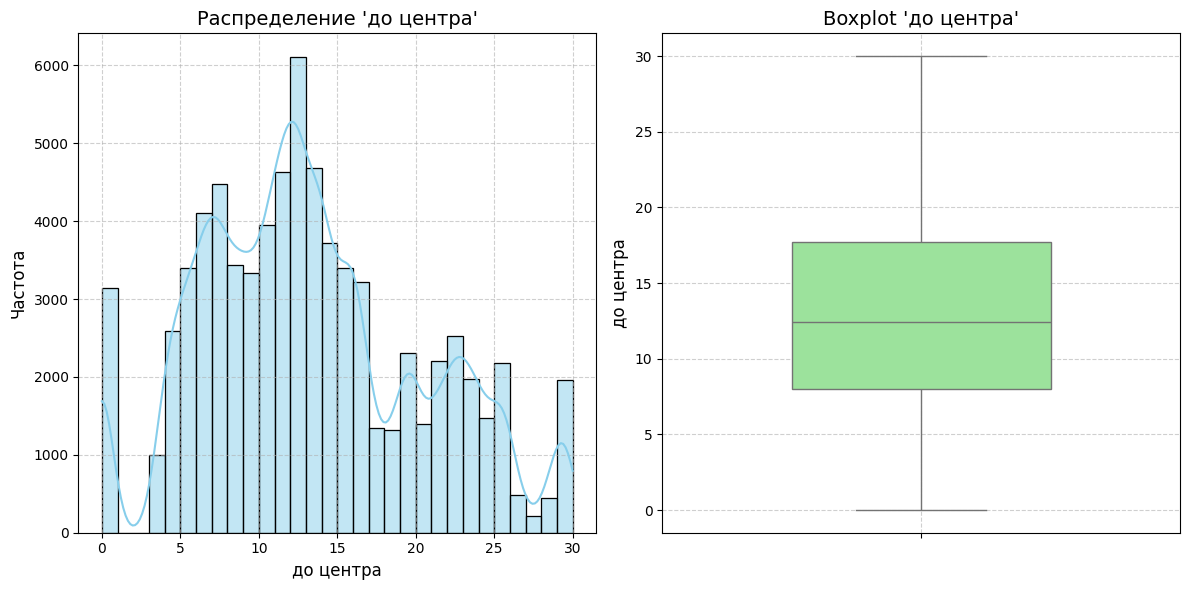

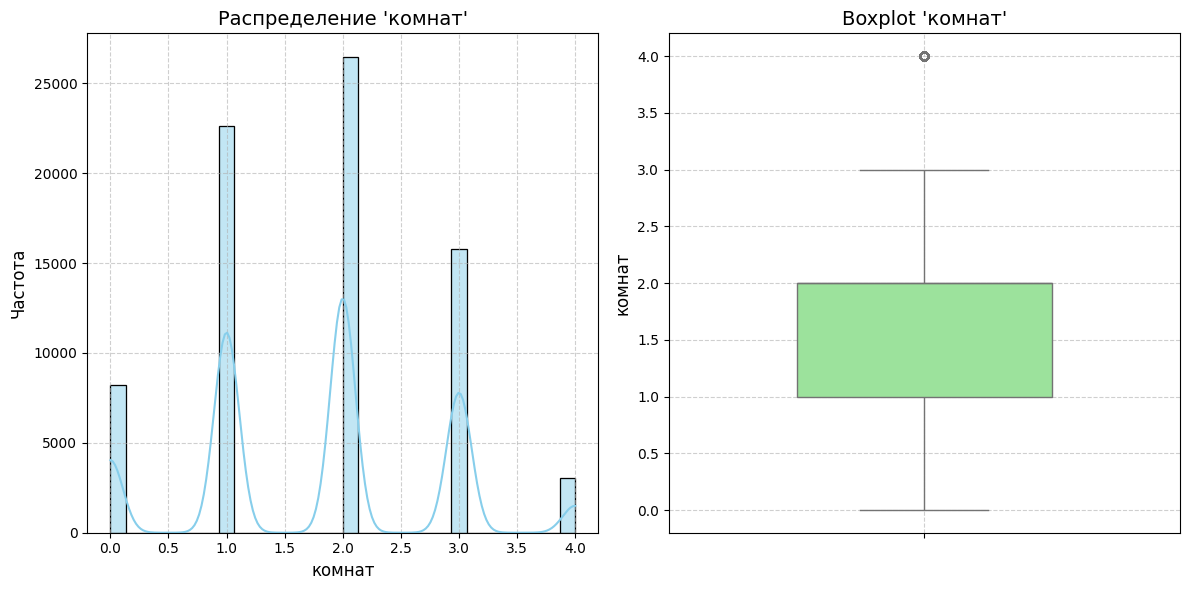

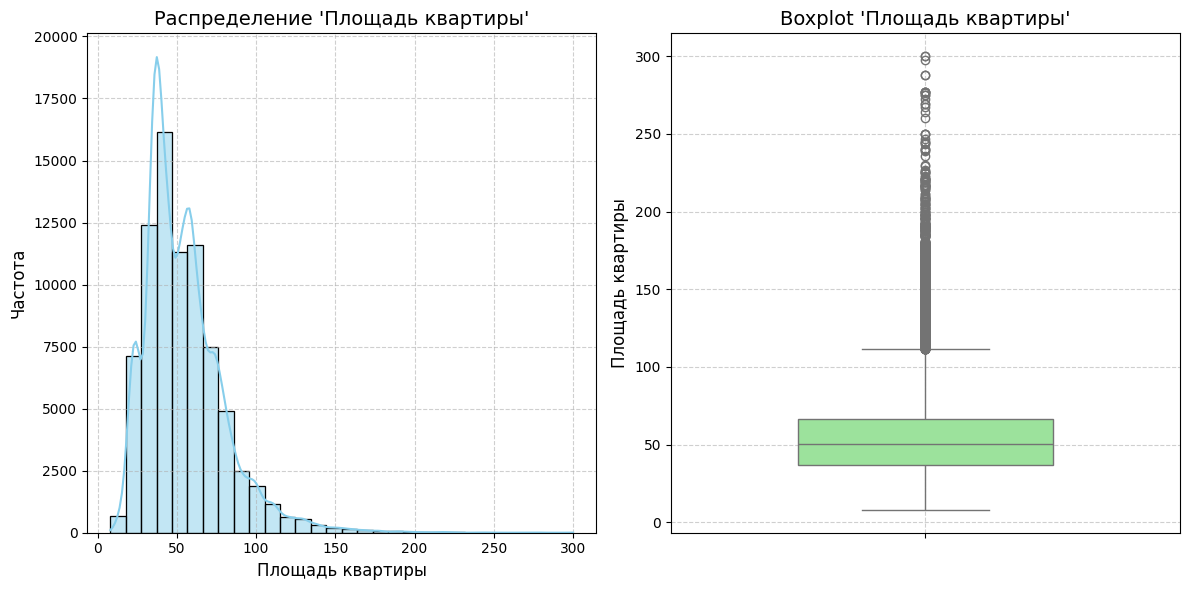

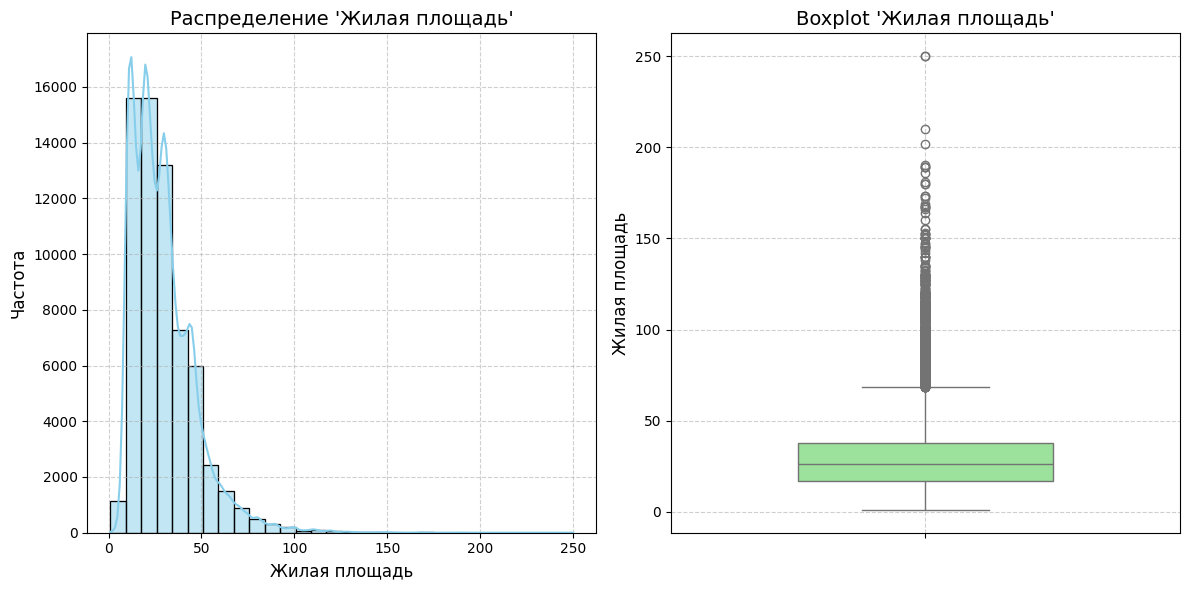

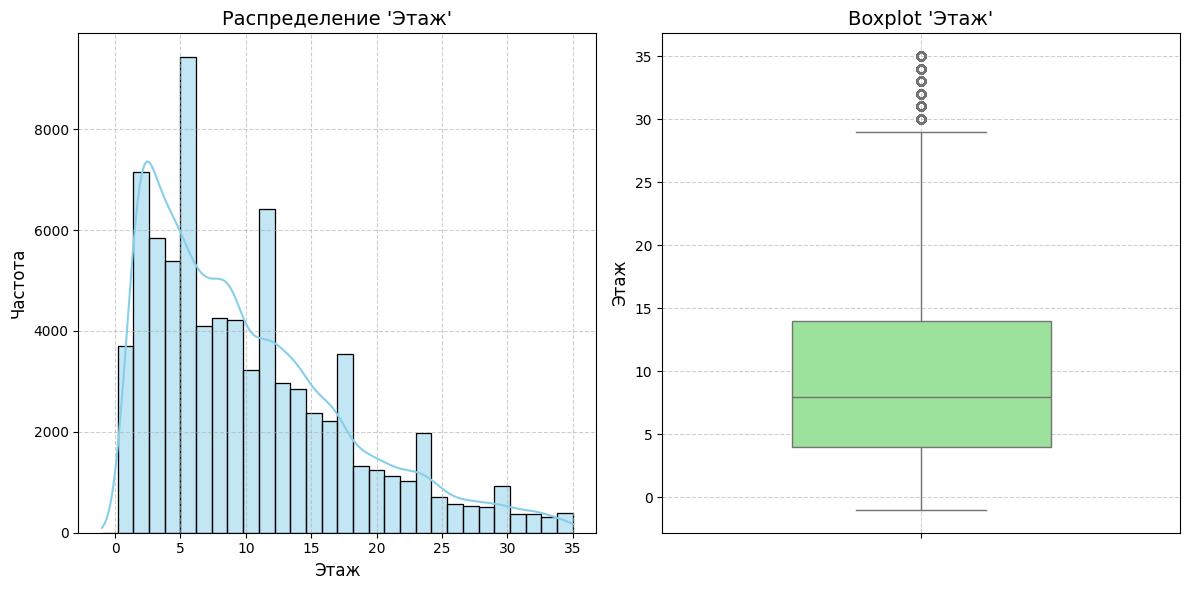

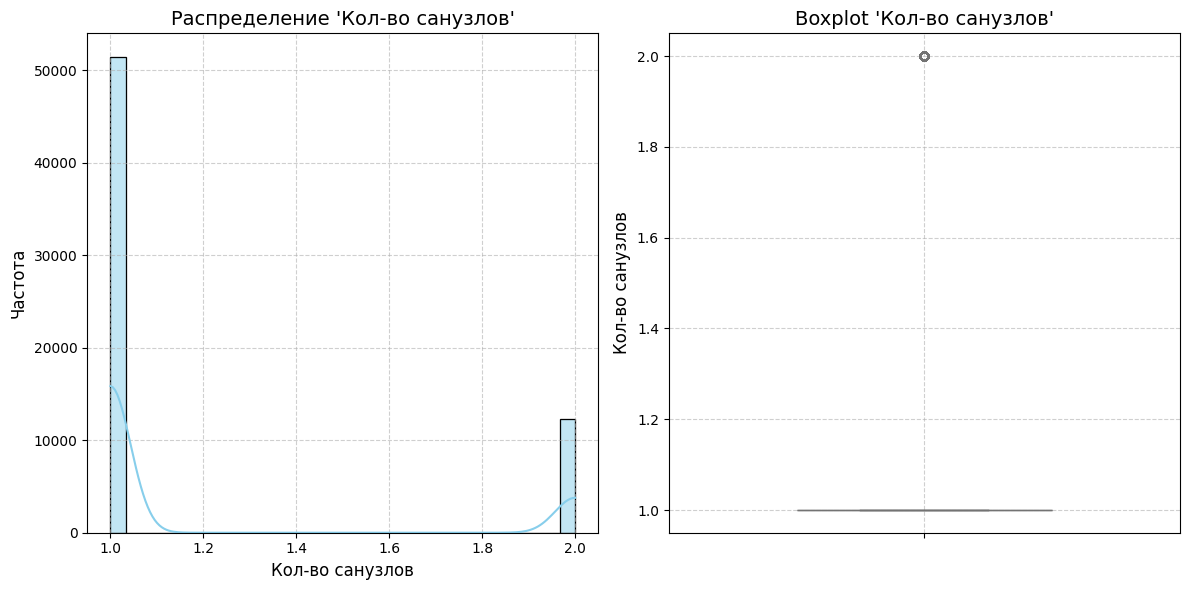

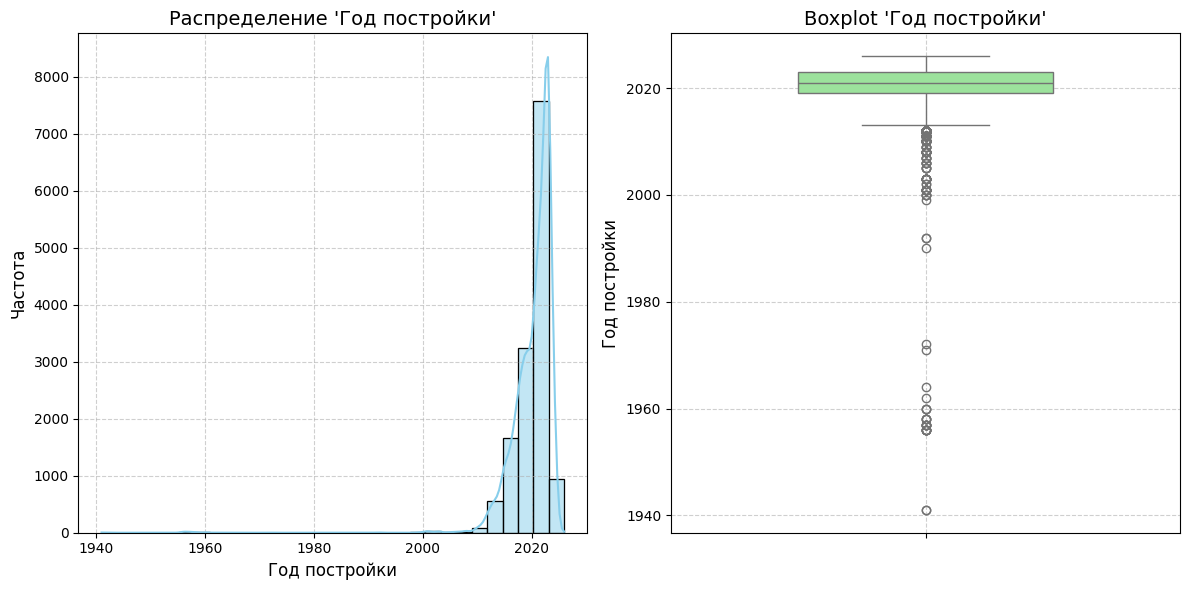

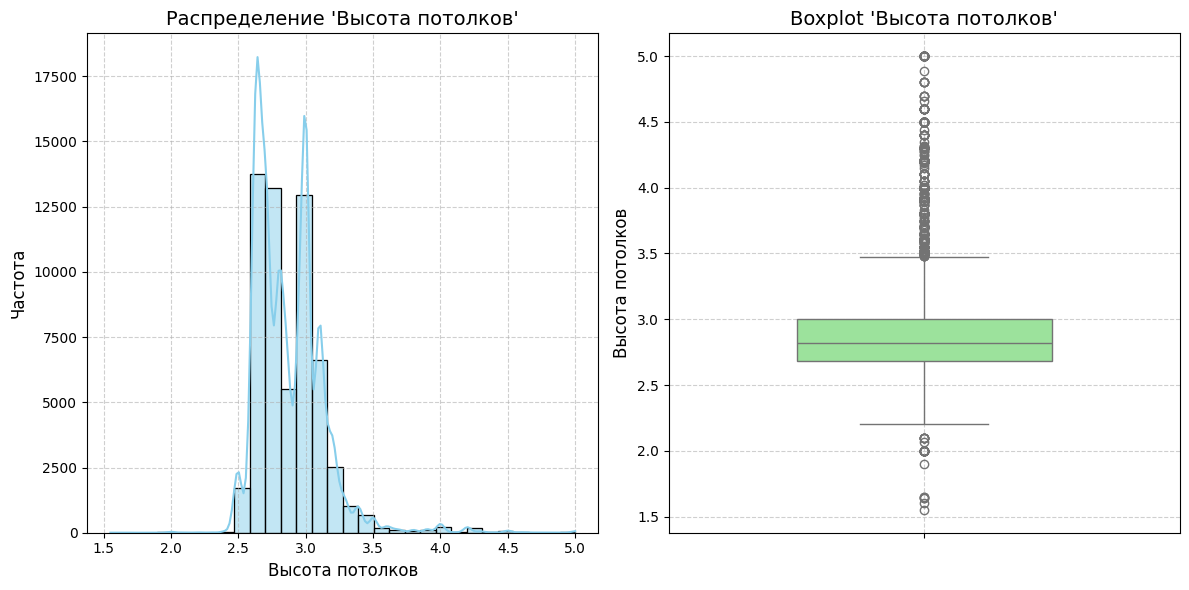

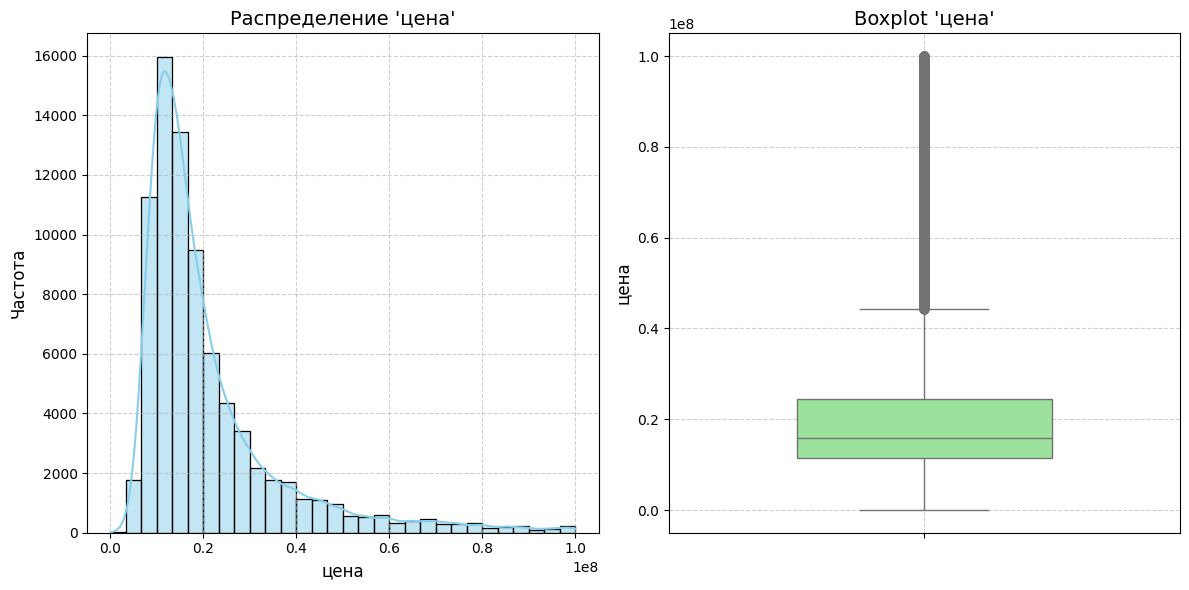

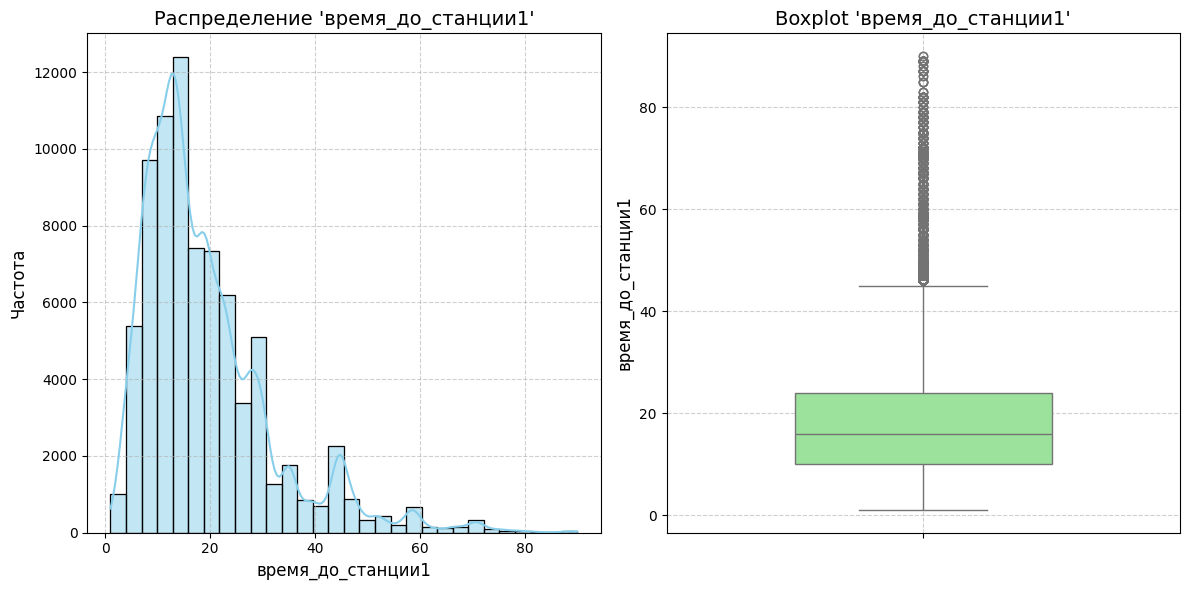

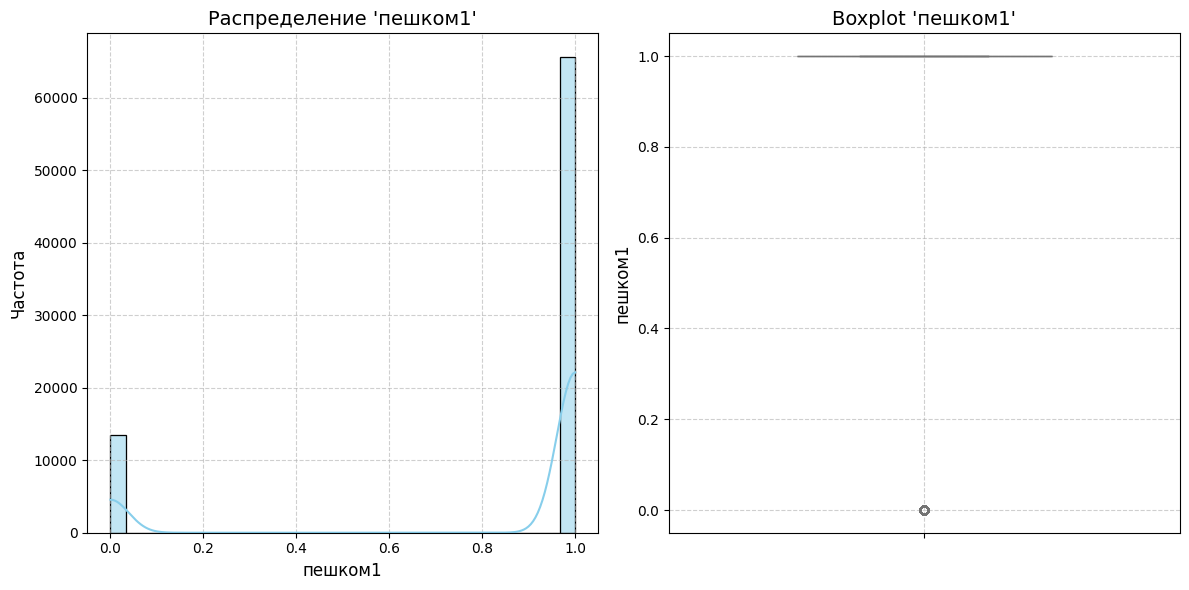

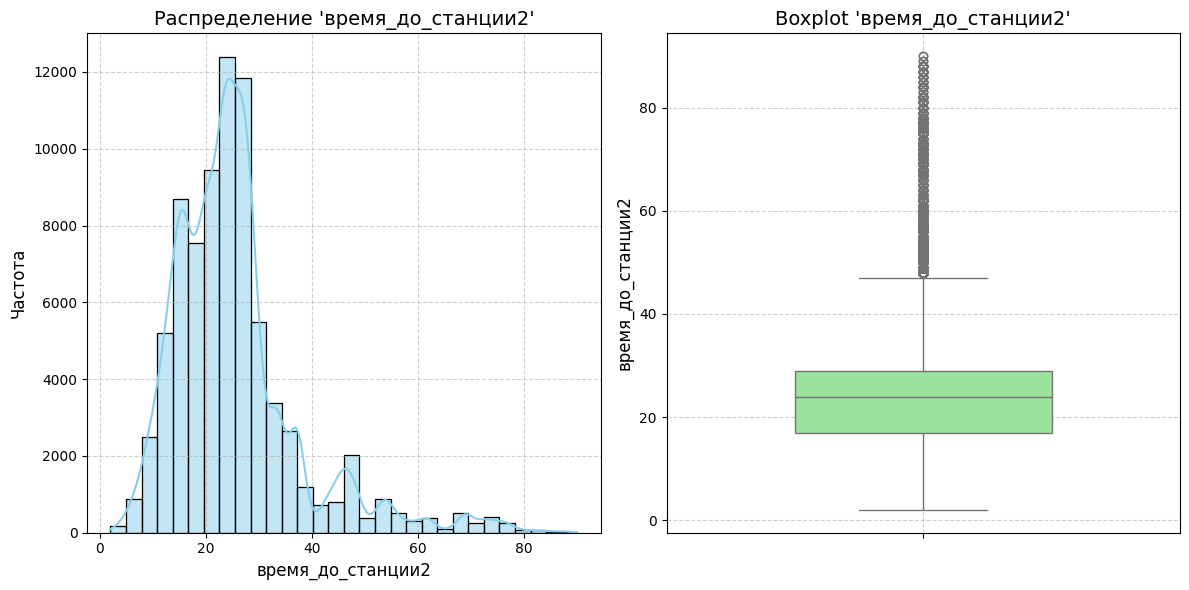

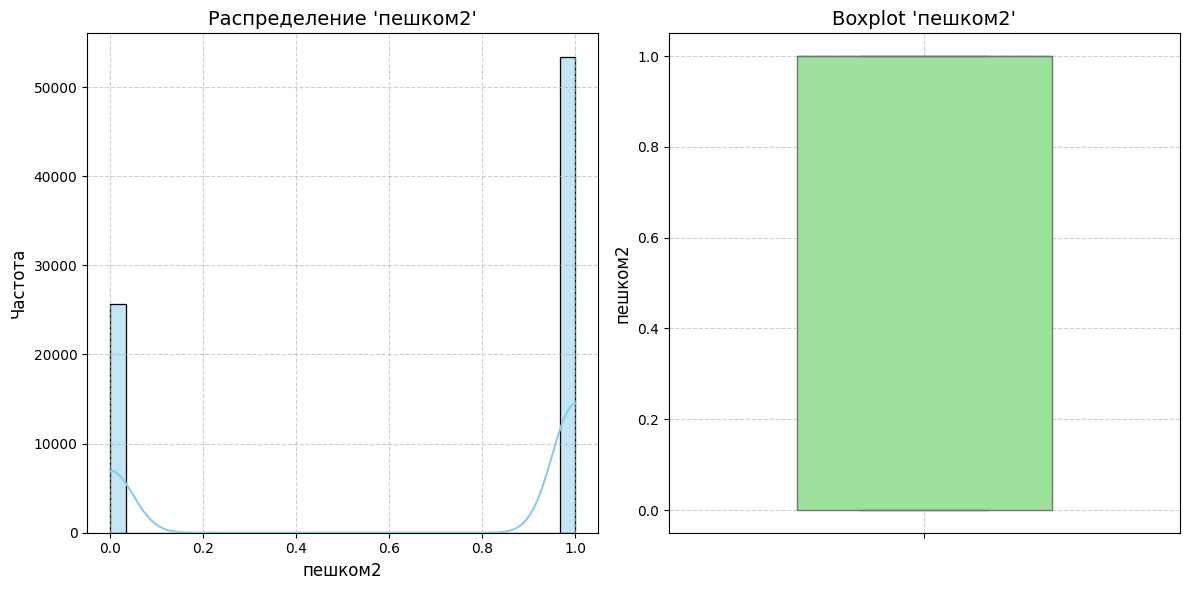

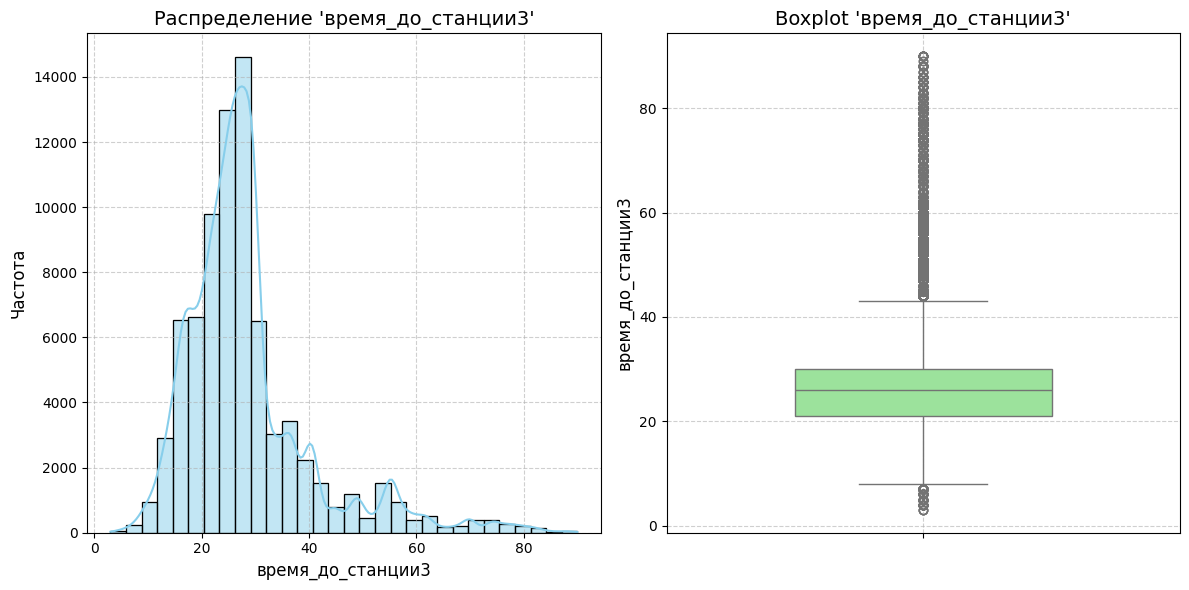

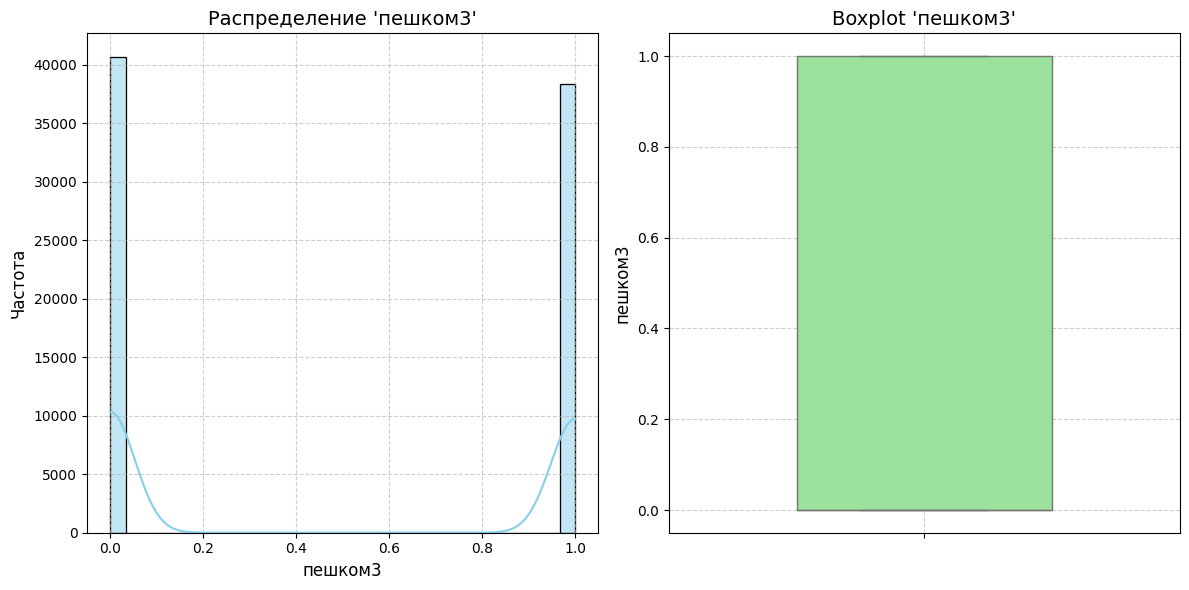

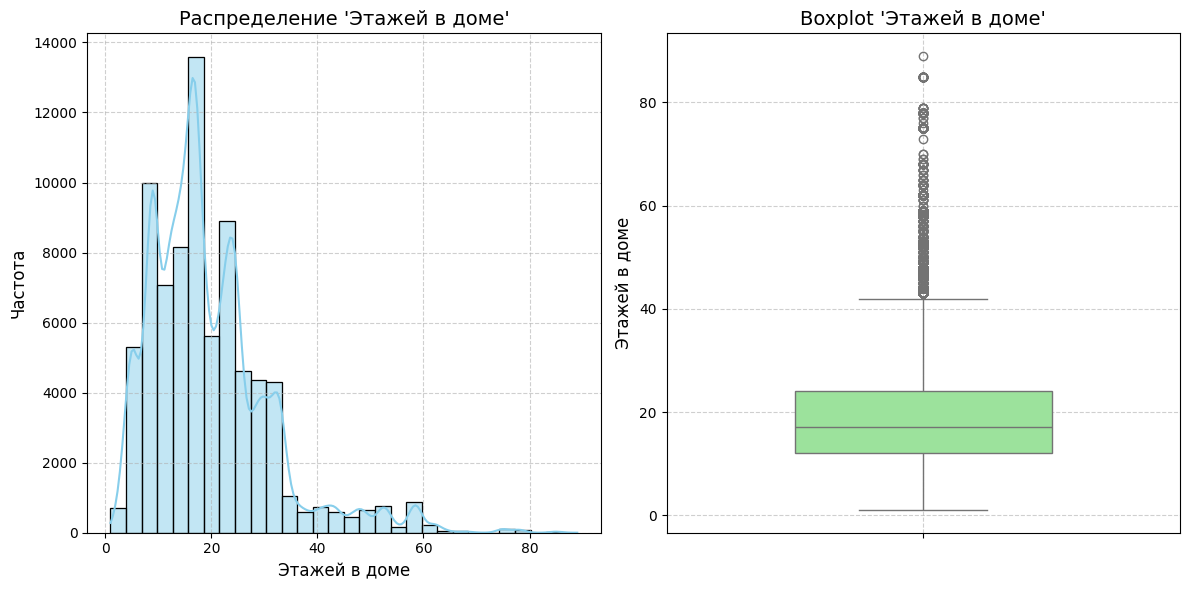

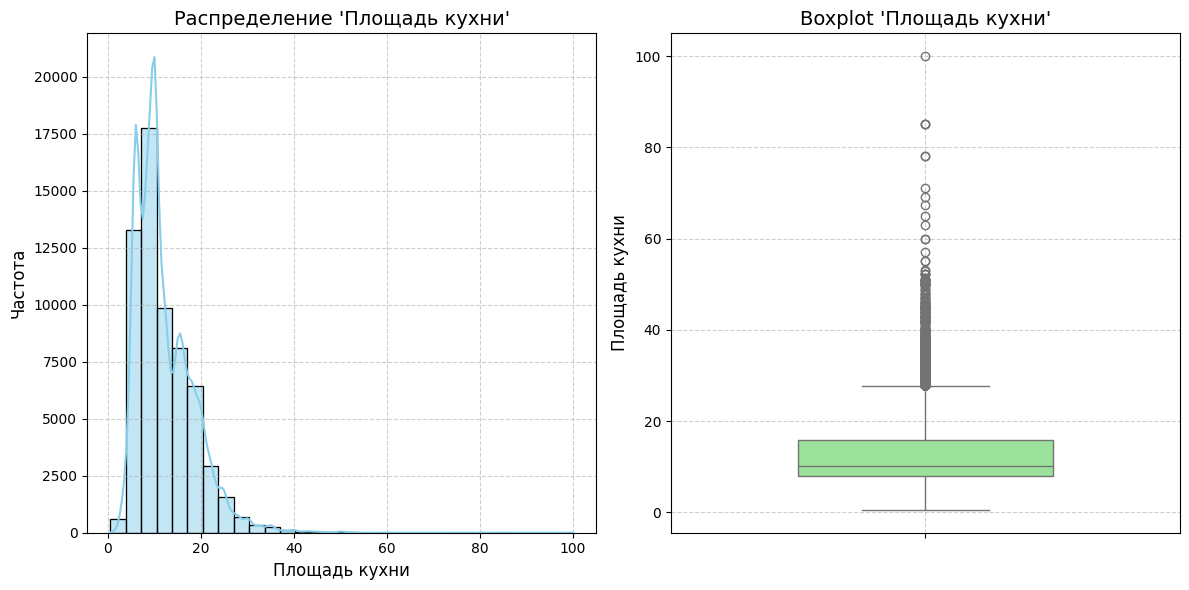

In [246]:
def plot_feature_distributions(data, features):
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        sns.histplot(data[feature], bins=30, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
        axes[0].set_title(f"Распределение '{feature}'", fontsize=14)
        axes[0].set_xlabel(feature, fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(visible=True, linestyle='--', alpha=0.6)

        sns.boxplot(y=data[feature], ax=axes[1], color='lightgreen', width=0.5)
        axes[1].set_title(f"Boxplot '{feature}'", fontsize=14)
        axes[1].set_ylabel(feature, fontsize=12)
        axes[1].grid(visible=True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

numerical_features = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
plot_feature_distributions(df_cleaned, numerical_features)

In [247]:
correlation_matrix = df_cleaned.corr(numeric_only=True)
correlation_matrix

до центра    комнат  Площадь квартиры  Жилая площадь  \
до центра           1.000000 -0.099146         -0.174628      -0.195293   
комнат             -0.099146  1.000000          0.824615       0.813994   
Площадь квартиры   -0.174628  0.824615          1.000000       0.892663   
Жилая площадь      -0.195293  0.813994          0.892663       1.000000   
Этаж                0.015536 -0.043027          0.010385      -0.085846   
Кол-во санузлов    -0.107127  0.399385          0.522862       0.363304   
Год постройки      -0.090598 -0.051773         -0.134801      -0.142282   
Высота потолков    -0.252172  0.110855          0.272945       0.230416   
цена               -0.475262  0.507659          0.737699       0.639683   
время_до_станции1   0.556190 -0.100937         -0.129311      -0.160865   
пешком1            -0.512516  0.075914          0.104196       0.112177   
время_до_станции2   0.630814 -0.105947         -0.140277      -0.164447   
пешком2            -0.582050  0.086858          0.137632       0.136987   
время_до_станции3   0.599649 -0.093101         -0.125141      -0.149300   
пешком3            -0.578916  0.087965          0.136540       0.149064   
Этажей в доме      -0.060102 -0.048301          0.040356      -0.082119   
Площадь кухни      -0.096491  0.123139          0.409672       0.044413   

                       Этаж  Кол-во санузлов  Год постройки  Высота потолков  \
до центра          0.015536        -0.107127      -0.090598        -0.252172   
комнат            -0.043027         0.399385      -0.051773         0.110855   
Площадь квартиры   0.010385         0.522862      -0.134801         0.272945   
Жилая площадь     -0.085846         0.363304      -0.142282         0.230416   
Этаж               1.000000         0.119707       0.062264         0.007667   
Кол-во санузлов    0.119707         1.000000       0.028756         0.181518   
Год постройки      0.062264         0.028756       1.000000         0.026399   
Высота потолков    0.007667         0.181518       0.026399         1.000000   
цена               0.083900         0.465243      -0.080486         0.473411   
время_до_станции1 -0.035708        -0.030720       0.054770        -0.090995   
пешком1            0.078380         0.055697       0.010051         0.062861   
время_до_станции2 -0.031799        -0.035660       0.065385        -0.117645   
пешком2            0.028133         0.061445       0.070128         0.086110   
время_до_станции3 -0.027368        -0.033112       0.068323        -0.095127   
пешком3           -0.000233         0.035176       0.043001         0.145192   
Этажей в доме      0.598037         0.173087       0.078444         0.071859   
Площадь кухни      0.214559         0.419167       0.040854         0.218645   

                       цена  время_до_станции1   пешком1  время_до_станции2  \
до центра         -0.475262           0.556190 -0.512516           0.630814   
комнат             0.507659          -0.100937  0.075914          -0.105947   
Площадь квартиры   0.737699          -0.129311  0.104196          -0.140277   
Жилая площадь      0.639683          -0.160865  0.112177          -0.164447   
Этаж               0.083900          -0.035708  0.078380          -0.031799   
Кол-во санузлов    0.465243          -0.030720  0.055697          -0.035660   
Год постройки     -0.080486           0.054770  0.010051           0.065385   
Высота потолков    0.473411          -0.090995  0.062861          -0.117645   
цена               1.000000          -0.292726  0.255182          -0.325594   
время_до_станции1 -0.292726           1.000000 -0.766547           0.909852   
пешком1            0.255182          -0.766547  1.000000          -0.742610   
время_до_станции2 -0.325594           0.909852 -0.742610           1.000000   
пешком2            0.303032          -0.672411  0.652016          -0.634474   
время_до_станции3 -0.298736           0.911158 -0.754421           0.928272   
пешком3            0.305014          -0.51

In [14]:
#Как и в изначальном EDA уберем колонки из-за сильной зависимости между ними
df_cleaned = df_cleaned.drop(['Жилая площадь', 'Этажей в доме', 'пешком1','пешком2','пешком3'], axis=1)

In [249]:
# Найти примеры заполненных столбцов
filled_columns_examples = {}
for column in df_cleaned.columns:
    filled_example = df_cleaned[column].dropna().iloc[0] if not df_cleaned[column].dropna().empty else None
    filled_columns_examples[column] = filled_example

In [250]:
filled_columns_examples
#посмотрим как выглядит пример каждого заполненного столбца

{'до центра': 7.9,
 'комнат': 0.0,
 'Площадь квартиры': 23.0,
 'Этаж': 20.0,
 'Санузел': 'совмещённый',
 'Кол-во санузлов': 1.0,
 'Ремонт': 'Нужен ремонт',
 'Вид из окна': 'во двор',
 'Год постройки': 2024.0,
 'Высота потолков': 3.0,
 'Лифт': 'есть',
 'Материал стен': 'монолит',
 'Парковка': 'подземная',
 'цена': 11000000.0,
 'станция1': 'Нагатинская',
 'время_до_станции1': 19.0,
 'станция2': 'Коломенская',
 'время_до_станции2': 24.0,
 'станция3': 'Верхние Котлы',
 'время_до_станции3': 28.0,
 'Отделка': 'без отделки',
 'Срок сдачи': '4\xa0кв.\xa02025\xa0г.',
 'Временная эпоха': 'сталинка',
 'Отопление': 'центральное',
 'Тип жилья': 'апартаменты',
 'Балкон/лоджия': 'есть',
 'Серия дома': '1-511',
 'Территория': 'закрытая',
 'Вид из окон': 'во двор и на улицу',
 'Хорошая школа': 'Спортивная площадка',
 'Парк или зона отдыха': 'Торговый центр',
 'Фитнес клуб': 'Спортивная площадка',
 'Детский сад': 'Торговый центр',
 'Торговый центр': 'Фитнес клуб',
 'Хорошие школы': 'Спортивная площадка'

In [251]:
#зафиксируем категориальные признаки, в которых много уникальных значений
cat_cols = df_cleaned.select_dtypes(include=['object']).columns

for col in cat_cols:
    unique_values = df_cleaned[col].nunique()
    print(f"{col}: {unique_values} уникальных значений")

Санузел: 2 уникальных значений
Ремонт: 6 уникальных значений
Вид из окна: 2 уникальных значений
Лифт: 1 уникальных значений
Материал стен: 6 уникальных значений
Парковка: 3 уникальных значений
станция1: 285 уникальных значений
станция2: 289 уникальных значений
станция3: 289 уникальных значений
Отделка: 3 уникальных значений
Срок сдачи: 25 уникальных значений
Временная эпоха: 3 уникальных значений
Отопление: 2 уникальных значений
Тип жилья: 1 уникальных значений
Балкон/лоджия: 1 уникальных значений
Серия дома: 47 уникальных значений
Территория: 1 уникальных значений
Вид из окон: 1 уникальных значений
Хорошая школа: 5 уникальных значений
Парк или зона отдыха: 3 уникальных значений
Фитнес клуб: 1 уникальных значений
Детский сад: 4 уникальных значений
Торговый центр: 2 уникальных значений
Хорошие школы: 4 уникальных значений


In [252]:
#Срок сдачи - можно перевести в числовой формат
df_cleaned['Срок сдачи'].unique()

array([nan, '4\xa0кв.\xa02025\xa0г.', '4\xa0кв.\xa02026\xa0г.',
       '2\xa0кв.\xa02026\xa0г.', '2\xa0кв.\xa02027\xa0г.',
       '4\xa0кв.\xa02024\xa0г.', '3\xa0кв.\xa02025\xa0г.', '2025\xa0г.',
       '4\xa0кв.\xa02027\xa0г.', '2024\xa0г.', '2028\xa0г.',
       '3\xa0кв.\xa02028\xa0г.', '2\xa0кв.\xa02025\xa0г.',
       '1\xa0кв.\xa02025\xa0г.', '3\xa0кв.\xa02024\xa0г.',
       '3\xa0кв.\xa02026\xa0г.', '1\xa0кв.\xa02024\xa0г.', '2026\xa0г.',
       '2\xa0кв.\xa02028\xa0г.', '2\xa0кв.\xa02024\xa0г.', '2027\xa0г.',
       '1\xa0кв.\xa02028\xa0г.', '1\xa0кв.\xa02026\xa0г.',
       '1\xa0кв.\xa02027\xa0г.', '3\xa0кв.\xa02027\xa0г.', 'Неизвестно'],
      dtype=object)

In [15]:
import re
import numpy as np
import pandas as pd

def convert_srok(s):
    if pd.isna(s) or s.strip() in ["Неизвестно"]:
        return np.nan
    s = s.replace('\xa0', ' ')
    # Если указаны квартал и год, извлекаем их
    m = re.search(r'(\d)\s*кв\.\s*(\d{4})', s)
    if m:
        quarter = int(m.group(1))
        year = int(m.group(2))
        # Преобразуем: Q1 -> year, Q2 -> year+0.25, Q3 -> year+0.5, Q4 -> year+0.75
        return year + (quarter - 1) / 4.0
    else:
        # Если указан только год, извлекаем его
        m_year = re.search(r'(\d{4})', s)
        if m_year:
            return int(m_year.group(1))
        else:
            return np.nan
df_cleaned['Срок сдачи'] = df_cleaned['Срок сдачи'].apply(convert_srok)

In [16]:
df_cleaned['Год постройки'] = df_cleaned['Год постройки'].where(df_cleaned['Год постройки'] > 0, df_cleaned['Срок сдачи'])
df_cleaned = df_cleaned.drop(columns=['Срок сдачи'])

In [17]:
#Заполним пропуски в столбце `Ремонт` значениями из столбца `Отделка`, если они отсутствуют, затем удалим столбец `Отделка`
df_cleaned['Отделка'] = df_cleaned['Отделка'].replace({
    'без отделки': 'Без отделки',
    'чистовая': 'Чистовая отделка',
    'предчистовая': 'Предчистовая отделка'
})

df_cleaned['Ремонт'] = df_cleaned['Ремонт'].fillna(df_cleaned['Отделка'])
df_cleaned = df_cleaned.drop(columns=['Отделка'])

In [18]:
#преобразуем float64 признаки в float32
float_cols = df_cleaned.select_dtypes(include=['float64']).columns
df_cleaned[float_cols] = df_cleaned[float_cols].astype('float32')

In [19]:
from sklearn.model_selection import train_test_split
df_cleaned = df_cleaned[df_cleaned['цена'].notna()]
X = df_cleaned.drop(columns=['цена'])
y = df_cleaned['цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [281]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55573 entries, 102397 to 20254
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   до центра             52531 non-null  float32
 1   комнат                53245 non-null  float32
 2   Площадь квартиры      55566 non-null  float32
 3   Этаж                  55316 non-null  float32
 4   Санузел               36852 non-null  object 
 5   Кол-во санузлов       44605 non-null  float32
 6   Ремонт                40367 non-null  object 
 7   Вид из окна           31226 non-null  object 
 8   Год постройки         34254 non-null  float32
 9   Высота потолков       41344 non-null  float32
 10  Лифт                  42594 non-null  object 
 11  Материал стен         47599 non-null  object 
 12  Парковка              29548 non-null  object 
 13  станция1              55406 non-null  object 
 14  время_до_станции1     55406 non-null  float32
 15  станция2           

In [20]:
"""
Этот блок кода объединяет информацию из нескольких категориальных колонок, содержащих неочевидные значения 5 последних признаков
из аутпута выше (хорошая школа, зона отдыха и т.д.),в одну объединенную переменную для каждой строки. 
"""
from sklearn.preprocessing import MultiLabelBinarizer

# Список колонок, значения которых нужно объединить в одну переменную
cols = ['Хорошая школа', 'Парк или зона отдыха', 'Фитнес клуб', 'Детский сад', 'Торговый центр', 'Хорошие школы']

# Функция для объединения значений из указанных колонок в один список для каждой строки
def combine_factors(row):
    factors = []
    for col in cols:
        value = row[col]
        if pd.notna(value):
            factors.append(value)
    # Используем set для удаления дублирующих значений и возвращаем как список
    return list(set(factors))

# Создаем новую колонку 'combined_factors', которая содержит объединенные значения из выбранных колонок
df_cleaned['combined_factors'] = df_cleaned.apply(combine_factors, axis=1)

# Если df_cleaned содержит столбец 'combined_factors', можно обновить X_train и X_test:
X_train['combined_factors'] = df_cleaned.loc[X_train.index, 'combined_factors']
X_test['combined_factors'] = df_cleaned.loc[X_test.index, 'combined_factors']

# Применим MultiLabelBinarizer для train & test частей
mlb = MultiLabelBinarizer()
train_dummies = pd.DataFrame(mlb.fit_transform(X_train['combined_factors']), columns=mlb.classes_, index=X_train.index)
test_dummies = pd.DataFrame(mlb.transform(X_test['combined_factors']), columns=mlb.classes_, index=X_test.index)

# Объединяем бинарные столбцы с исходным DataFrame и удаляем исходные столбцы и объединенную колонку
train_dummies = train_dummies.add_suffix('_dummy')
test_dummies = test_dummies.add_suffix('_dummy')

X_train = pd.concat([X_train, train_dummies], axis=1)
X_test = pd.concat([X_test, test_dummies], axis=1)

# Удаляем столбцы, если они существуют в DataFrame
columns_to_remove = cols + ['combined_factors']
X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=[col for col in columns_to_remove if col in X_test.columns], inplace=True)
df_cleaned = df_cleaned.drop(columns='combined_factors')

In [314]:
!pip install catboost


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#Обработка пропущенных категориальных значений для CatBoost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import r2_score

cat_cols_to_encode = X_train.select_dtypes(include=['object']).columns
# Заполняем NaN для категориальных признаков в X_train и X_test строкой "missing"
for col in cat_cols_to_encode:
    X_train[col] = X_train[col].fillna("missing")
    X_test[col] = X_test[col].fillna("missing")

categorical_features_indices = [X_train.columns.get_loc(col) for col in cat_cols_to_encode]

# Создаем модель CatBoostRegressor с нужными параметрами
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100
)

# Обучаем модель на тренировочных данных, передавая индексы категориальных признаков
model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Делаем предсказания на тестовой выборке
y_pred = model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAPE на тестовой выборке:: {mape:.4f} ({mape * 100:.2f}%)")
print(f"RMSE на тестовой выборке:: {rmse:.2f}")

print(f"R² на тестовой выборке:: {r2:.4f}")

0:	learn: 14655686.9678473	total: 95.9ms	remaining: 1m 35s
100:	learn: 5013823.6039300	total: 4.13s	remaining: 36.8s
200:	learn: 4428248.5215271	total: 8.03s	remaining: 31.9s
300:	learn: 4158561.1289022	total: 12.1s	remaining: 28s
400:	learn: 3941044.3327908	total: 15.8s	remaining: 23.7s
500:	learn: 3779809.8040286	total: 19.6s	remaining: 19.5s
600:	learn: 3629382.6107220	total: 23.2s	remaining: 15.4s
700:	learn: 3503189.2186287	total: 26.9s	remaining: 11.5s
800:	learn: 3383319.8284033	total: 31.1s	remaining: 7.73s
900:	learn: 3295919.4494478	total: 34.8s	remaining: 3.82s
999:	learn: 3216664.9866855	total: 38.5s	remaining: 0us
MAPE на тестовой выборке:: 0.0903 (9.03%)
RMSE на тестовой выборке:: 3919376.15


In [289]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#подбор параметров Optuna для Catboost
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1500, log=True),
        'depth': trial.suggest_int('depth', 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 1e-1, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-4, 1e-1, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-4, 1e-1, log=True),
        'od_type': 'Iter',
        'od_wait': 100
    }

    model = CatBoostRegressor(**param, verbose=0)
    model.fit(X_train, y_train, cat_features=categorical_features_indices)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Обучение модели с лучшими гиперпараметрами
best_params = study.best_trial.params
best_model = CatBoostRegressor(**best_params, verbose=100)
best_model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Предсказания и оценка модели
y_pred_best = best_model.predict(X_test)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"MAPE на тестовой выборке с лучшими гиперпараметрами: {mape_best:.4f} ({mape_best * 100:.2f}%)")
print(f"RMSE на тестовой выборке с лучшими гиперпараметрами: {rmse_best:.2f}")
print(f"R² на тестовой выборке с лучшими гиперпараметрами: {r2_best:.4f}")

[I 2025-03-10 20:11:25,258] A new study created in memory with name: no-name-c2c7aeae-2f83-4bea-9b75-fe2e4f9a6980


[I 2025-03-10 20:14:59,816] Trial 0 finished with value: 0.09474064820776597 and parameters: {'iterations': 1144, 'depth': 12, 'learning_rate': 0.006689839898484654, 'l2_leaf_reg': 0.0001649030547846861, 'border_count': 160, 'random_strength': 0.0021848450363847853, 'bagging_temperature': 0.00045259125704294077}. Best is trial 0 with value: 0.09474064820776597.
[I 2025-03-10 20:23:28,913] Trial 1 finished with value: 0.08395376827099295 and parameters: {'iterations': 554, 'depth': 15, 'learning_rate': 0.021511323483636362, 'l2_leaf_reg': 0.000414194771006632, 'border_count': 38, 'random_strength': 0.0008024633445433631, 'bagging_temperature': 0.001339487508100596}. Best is trial 1 with value: 0.08395376827099295.
[I 2025-03-10 20:24:45,689] Trial 2 finished with value: 0.13532744380022113 and parameters: {'iterations': 1484, 'depth': 7, 'learning_rate': 0.0030329543296131957, 'l2_leaf_reg': 0.0012133723104485047, 'border_count': 135, 'random_strength': 0.0008624345359538188, 'bagging_t

KeyboardInterrupt: 

In [293]:
import numpy as np
# Заполняем NaN для категориальных признаков в X_train и X_test где строка "missing"
# необходимо для дальнейших преобразований для XGBoost и LightGBM
for col in cat_cols_to_encode:
    X_train[col] = X_train[col].replace("missing", np.nan)
    X_test[col] = X_test[col].replace("missing", np.nan)

In [21]:
# Преобразуем числовые признаки из int64 в int32
int_cols = X_train.select_dtypes(include=['int64']).columns
X_train[int_cols] = X_train[int_cols].astype('int32')
X_test[int_cols] = X_test[int_cols].astype('int32')

In [22]:
#заполним пустые числовые значения с помощью KNNImputer
from sklearn.impute import KNNImputer

# Создаем экземпляр KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Применяем KNNImputer к числовым признакам
X_train_imputed = imputer.fit_transform(X_train.select_dtypes(include=['float32', 'int64']))
X_test_imputed = imputer.transform(X_test.select_dtypes(include=['float32', 'int64']))

# Преобразуем обратно в DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.select_dtypes(include=['float32', 'int64']).columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.select_dtypes(include=['float32', 'int64']).columns, index=X_test.index)

# Объединяем с категориальными признаками
X_train = pd.concat([X_train_imputed, X_train.select_dtypes(exclude=['float32', 'int64'])], axis=1)
X_test = pd.concat([X_test_imputed, X_test.select_dtypes(exclude=['float32', 'int64'])], axis=1)

In [324]:
#посмотрим уникальные значения категориальных признаков в изначальном датасете
cat_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_count = df_cleaned[col].nunique(dropna=True)
    filled_count = df_cleaned[col].count()
    if unique_count <= 100:
        print(f"{col} ({unique_count} уникальных значений, {filled_count} заполненных значений):")
        print(df_cleaned[col].unique())
        print("-" * 40)

Санузел (2 уникальных значений, 52521 заполненных значений):
['совмещённый' nan 'раздельный']
----------------------------------------
Ремонт (8 уникальных значений, 57631 заполненных значений):
['Нужен ремонт' 'Без отделки' 'Чистовая отделка' nan 'Черновая отделка'
 'Хороший' 'Дизайнерский' 'Евро' 'Предчистовая отделка']
----------------------------------------
Вид из окна (2 уникальных значений, 44752 заполненных значений):
['во двор' nan 'на улицу']
----------------------------------------
Лифт (1 уникальных значений, 60778 заполненных значений):
['есть' nan]
----------------------------------------
Материал стен (6 уникальных значений, 67898 заполненных значений):
['монолит' 'кирпич' nan 'панель' 'кирпич-монолит' 'блок' 'дерево']
----------------------------------------
Парковка (3 уникальных значений, 42212 заполненных значений):
['подземная' nan 'закрытая' 'открытая']
----------------------------------------
Временная эпоха (3 уникальных значений, 12736 заполненных значений):
[na

In [23]:
from sklearn.preprocessing import OneHotEncoder

"""Перейдем к обработке категориальных признаков - применим OneHotEncoding 
Выбираем категориальные признаки с количеством уникальных значений меньше 10"""

cat_cols = X_train.select_dtypes(include=['object']).columns
cat_cols_to_encode = [col for col in cat_cols if df_cleaned[col].nunique() < 10]

# Применяем OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_features = encoder.fit_transform(X_train[cat_cols_to_encode])

# Создаем DataFrame с закодированными признаками
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols_to_encode), index=X_train.index)

# Объединяем закодированные признаки с исходным DataFrame
X_train = pd.concat([X_train.drop(columns=cat_cols_to_encode), encoded_df], axis=1)

In [24]:
# Применяем OneHotEncoder к тестовой выборке
encoded_features_test = encoder.transform(X_test[cat_cols_to_encode])

# Создаем DataFrame с закодированными признаками
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(cat_cols_to_encode), index=X_test.index)

# Объединяем закодированные признаки с исходным DataFrame
X_test = pd.concat([X_test.drop(columns=cat_cols_to_encode), encoded_df_test], axis=1)

In [25]:
# для категорий станция1 станция2 станция3 для пропусков возьмем самые часто встречающиеся значения
from sklearn.preprocessing import LabelEncoder

for col in ['станция1', 'станция2', 'станция3']:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')

# Применяем Label Encoding к каждой колонке
for col in ['станция1', 'станция2', 'станция3']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col].map(lambda s: 'missing' if s not in le.classes_ else s))

In [328]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55573 entries, 102397 to 20254
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   до центра                     55573 non-null  float32
 1   комнат                        55573 non-null  float32
 2   Площадь квартиры              55573 non-null  float32
 3   Этаж                          55573 non-null  float32
 4   Кол-во санузлов               55573 non-null  float32
 5   Год постройки                 55573 non-null  float32
 6   Высота потолков               55573 non-null  float32
 7   время_до_станции1             55573 non-null  float32
 8   время_до_станции2             55573 non-null  float32
 9   время_до_станции3             55573 non-null  float32
 10  Площадь кухни                 55573 non-null  float32
 11  станция1                      55573 non-null  int64  
 12  станция2                      55573 non-null  int64  
 13  с

In [26]:
# Заполняем пустые значения в столбце "Серия дома" специальным значением "Неизвестно" для обучающей и тестовой выборки
X_train['Серия дома'] = X_train['Серия дома'].fillna('Неизвестно')
X_test['Серия дома'] = X_test['Серия дома'].fillna('Неизвестно')

In [334]:
!pip install xgboost

In [340]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55573 entries, 102397 to 20254
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   до центра                     55573 non-null  float32
 1   комнат                        55573 non-null  float32
 2   Площадь квартиры              55573 non-null  float32
 3   Этаж                          55573 non-null  float32
 4   Кол-во санузлов               55573 non-null  float32
 5   Год постройки                 55573 non-null  float32
 6   Высота потолков               55573 non-null  float32
 7   время_до_станции1             55573 non-null  float32
 8   время_до_станции2             55573 non-null  float32
 9   время_до_станции3             55573 non-null  float32
 10  Площадь кухни                 55573 non-null  float32
 11  станция1                      55573 non-null  int64  
 12  станция2                      55573 non-null  int64  
 13  с

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score

#Преобразуем категориальные столбцы в тип category
X_train['Серия дома'] = X_train['Серия дома'].astype('category')
X_test['Серия дома'] = X_test['Серия дома'].astype('category')

# Convert the data to DMatrix format which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test,enable_categorical=True)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the model
num_rounds = 1000
model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=100)

# Make predictions
y_pred = model.predict(dtest)

# Calculate metrics
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAPE на тестовой выборке: {mape:.4f} ({mape * 100:.2f}%)")
print(f"RMSE на тестовой выборке: {rmse:.2f}")
print(f"R² на тестовой выборке: {r2:.4f}")

[0]	test-rmse:14353880.52690


[100]	test-rmse:4269922.26429
[200]	test-rmse:4127407.99792
[300]	test-rmse:4086625.30794
[400]	test-rmse:4075675.98298
[500]	test-rmse:4068146.34258
[600]	test-rmse:4062721.79144
[700]	test-rmse:4059864.44313
[800]	test-rmse:4059867.99383
[900]	test-rmse:4059148.56956
[914]	test-rmse:4058956.35454
MAPE на тестовой выборке: 0.1033 (10.33%)
RMSE на тестовой выборке: 4059006.25
R² на тестовой выборке: 0.9327


In [27]:
# Преобразуем числовые признаки в float32
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numerical_cols] = X_train[numerical_cols].astype('float32')
X_test[numerical_cols] = X_test[numerical_cols].astype('float32')

# Преобразуем категориальные признаки в тип category
categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_test[categorical_cols] = X_test[categorical_cols].astype('category')

# Проверим изменения
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55573 entries, 102397 to 20254
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   до центра                     55573 non-null  float32 
 1   комнат                        55573 non-null  float32 
 2   Площадь квартиры              55573 non-null  float32 
 3   Этаж                          55573 non-null  float32 
 4   Кол-во санузлов               55573 non-null  float32 
 5   Год постройки                 55573 non-null  float32 
 6   Высота потолков               55573 non-null  float32 
 7   время_до_станции1             55573 non-null  float32 
 8   время_до_станции2             55573 non-null  float32 
 9   время_до_станции3             55573 non-null  float32 
 10  Площадь кухни                 55573 non-null  float32 
 11  станция1                      55573 non-null  float32 
 12  станция2                      55573 non-null  

In [346]:
#подберем гиперпараметры для XGBoost
import optuna
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'eta': trial.suggest_float('eta', 1e-4, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-4, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-4, 1.0, log=True),
        'eval_metric': 'rmse'
    }

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    model = xgb.train(param, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)
    y_pred = model.predict(dtest)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

best_params = study.best_trial.params
best_model = xgb.train(best_params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=100)


y_pred_best = best_model.predict(dtest)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"MAPE на тестовой выборке с лучшими гиперпараметрами: {mape_best:.4f} ({mape_best * 100:.2f}%)")
print(f"RMSE на тестовой выборке с лучшими гиперпараметрами: {rmse_best:.2f}")
print(f"R² на тестовой выборке с лучшими гиперпараметрами: {r2_best:.4f}")


[I 2025-03-10 21:57:14,823] A new study created in memory with name: no-name-e38cf659-3cd0-40d6-be7d-d4217b86b102
[I 2025-03-10 21:57:20,299] Trial 0 finished with value: 0.1555217206478119 and parameters: {'max_depth': 4, 'eta': 0.006051212543801809, 'subsample': 0.9650682040587832, 'colsample_bytree': 0.9254713711361209, 'lambda': 0.34484157719312764, 'alpha': 0.000778873471844448}. Best is trial 0 with value: 0.1555217206478119.
[I 2025-03-10 21:57:39,094] Trial 1 finished with value: 0.09568192809820175 and parameters: {'max_depth': 11, 'eta': 0.023597608217062863, 'subsample': 0.8675133943865061, 'colsample_bytree': 0.6152609286310791, 'lambda': 0.30730239956755, 'alpha': 0.0002524587436749681}. Best is trial 1 with value: 0.09568192809820175.
[I 2025-03-10 21:58:08,723] Trial 2 finished with value: 0.307071715593338 and parameters: {'max_depth': 11, 'eta': 0.001028123289793807, 'subsample': 0.5711808018098108, 'colsample_bytree': 0.5138292734566037, 'lambda': 0.000384577107140490

Number of finished trials: 50
Best trial: {'max_depth': 12, 'eta': 0.052334147151371725, 'subsample': 0.947986259109503, 'colsample_bytree': 0.531758248415418, 'lambda': 0.4626453641183538, 'alpha': 0.01346128722153246}
[0]	test-rmse:14960875.01706
[100]	test-rmse:4330253.94599
[200]	test-rmse:4140637.09196
[300]	test-rmse:4097396.89065
[400]	test-rmse:4081167.05345
[500]	test-rmse:4072850.61469
[600]	test-rmse:4068311.69861
[700]	test-rmse:4066084.33749
[800]	test-rmse:4064679.22478
[900]	test-rmse:4063972.36509
[937]	test-rmse:4063862.31272
MAPE на тестовой выборке с лучшими гиперпараметрами: 0.0939 (9.39%)
RMSE на тестовой выборке с лучшими гиперпараметрами: 4063862.25
R² на тестовой выборке с лучшими гиперпараметрами: 0.9325


In [349]:
!pip install lightgbm

In [351]:
!pip install --upgrade lightgbm

In [ ]:
import optuna
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score
import lightgbm as lgb

# Получаем индексы категориальных столбцов
categorical_features_indices = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['category']).columns]

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 1.0, log=True)
    }
    
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features_indices)
    dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain, categorical_feature=categorical_features_indices)
    
    model = lgb.train(params, dtrain, valid_sets=[dtest],
                      num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)])
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

# Создаем исследование Optuna, минимизирующее MAPE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)

# Обучаем модель с лучшими гиперпараметрами
best_params = study.best_trial.params
dtrain_full = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features_indices)
dtest_full = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features_indices)
best_model = lgb.train(best_params, dtrain_full,
                       valid_sets=[dtest_full],
                       num_boost_round=1000,
                       callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)])

# Делаем предсказания и оцениваем модель
y_pred_best = best_model.predict(X_test, num_iteration=best_model.best_iteration)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"MAPE на тестовой выборке: {mape_best:.4f} ({mape_best * 100:.2f}%)")
print(f"RMSE на тестовой выборке: {rmse_best:.2f}")
print(f"R² на тестовой выборке: {r2_best:.4f}")

[I 2025-03-10 22:25:29,223] A new study created in memory with name: no-name-b35241ab-81ab-4e5a-9eb4-56b47fe255ce


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1.55247e+07
[200]	valid_0's rmse: 1.54081e+07
[300]	valid_0's rmse: 1.52953e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 1.51833e+07
[500]	valid_0's rmse: 1.5071e+07
[600]	valid_0's rmse: 1.49596e+07
[700]	valid_0's rmse: 1.48506e+07
[800]	valid_0's rmse: 1.47408e+07
[900]	valid_0's rmse

[I 2025-03-10 22:25:46,586] Trial 0 finished with value: 0.5938908693153613 and parameters: {'max_depth': 7, 'learning_rate': 0.0001027691747256099, 'num_leaves': 87, 'feature_fraction': 0.6659536659961298, 'bagging_fraction': 0.5310070278303571, 'bagging_freq': 5, 'lambda_l1': 0.30812881195274955, 'lambda_l2': 0.00016554174742810384}. Best is trial 0 with value: 0.5938908693153613.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:25:52,760] Trial 1 finished with value: 0.5966872610203517 and parameters: {'max_depth': 4, 'learning_rate': 0.00011206407871211247, 'num_leaves': 665, 'feature_fraction': 0.7181798998947723, 'bagging_fraction': 0.9085861619479223, 'bagging_freq': 4, 'lambda_l1': 0.013084758959462166, 'lambda_l2': 0.00029425055797482696}. Best is trial 0 with value: 0.5938908693153613.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:26:08,317] Trial 2 finished with value: 0.23318608690834008 and parameters: {'max_depth': 6, 'learning_rate': 0.001658968356316484, 'num_leaves': 2580, 'feature_fraction': 0.8094175142730895, 'bagging_fraction': 0.749080377755001, 'bagging_freq': 4, 'lambda_l1': 0.8307216982862408, 'lambda_l2': 0.0005897373139950918}. Best is trial 2 with value: 0.23318608690834008.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1.28589e+07
[200]	valid_0's rmse: 1.08137e+07
[300]	valid_0's rmse: 9.33892e+06
[400]	valid_0's rmse: 8.27336e+06
[500]	valid_0's rmse: 7.50682e+06
[600]	valid_0's rmse: 6.95687e+06
[700]	valid_0's rmse: 6.5568e+06
[800]	valid_0's rmse: 6.25623e+06
[900]	valid_0's rmse: 6.02784e+06
[1000]	valid_0's rmse: 5.85077e+06
Did not meet early stoppin

[I 2025-03-10 22:26:20,074] Trial 3 finished with value: 0.17522039484446647 and parameters: {'max_depth': 6, 'learning_rate': 0.002781566508242894, 'num_leaves': 44, 'feature_fraction': 0.8403221843852557, 'bagging_fraction': 0.8927983857298267, 'bagging_freq': 7, 'lambda_l1': 0.16071342092452934, 'lambda_l2': 0.1443601778348199}. Best is trial 3 with value: 0.17522039484446647.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 5.81594e+06
[200]	valid_0's rmse: 5.17409e+06
[300]	valid_0's rmse: 4.85932e+06
[400]	valid_0's rmse: 4.66684e+06
[500]	valid_0's rmse: 4.52866e+06
[600]	valid_0's rmse: 4.4203e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's rmse: 4.33042e+06
[LightGBM] [Warning] No further splits with positive g

[I 2025-03-10 22:26:26,646] Trial 4 finished with value: 0.10417343157197118 and parameters: {'max_depth': 6, 'learning_rate': 0.03869601329437383, 'num_leaves': 21, 'feature_fraction': 0.7154684475046319, 'bagging_fraction': 0.9492135645356075, 'bagging_freq': 7, 'lambda_l1': 0.12765879954296555, 'lambda_l2': 0.0002248782943133568}. Best is trial 4 with value: 0.10417343157197118.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:30:52,781] Trial 5 finished with value: 0.5316709627897006 and parameters: {'max_depth': 14, 'learning_rate': 0.00022545470499898756, 'num_leaves': 1587, 'feature_fraction': 0.5170884576702732, 'bagging_fraction': 0.9783234800190449, 'bagging_freq': 2, 'lambda_l1': 0.011449294755394593, 'lambda_l2': 0.0887009382129373}. Best is trial 4 with value: 0.10417343157197118.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:31:26,866] Trial 6 finished with value: 0.13152051618913108 and parameters: {'max_depth': 8, 'learning_rate': 0.003560980675661304, 'num_leaves': 307, 'feature_fraction': 0.5250453889748603, 'bagging_fraction': 0.6631851982953753, 'bagging_freq': 2, 'lambda_l1': 0.010803087333658805, 'lambda_l2': 0.13649141413310956}. Best is trial 4 with value: 0.10417343157197118.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:34:11,534] Trial 7 finished with value: 0.09160314785080709 and parameters: {'max_depth': 13, 'learning_rate': 0.0046597469292476105, 'num_leaves': 1487, 'feature_fraction': 0.6355547976183527, 'bagging_fraction': 0.8564245169860711, 'bagging_freq': 1, 'lambda_l1': 0.7163880061887492, 'lambda_l2': 0.007926622982133692}. Best is trial 7 with value: 0.09160314785080709.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1.04666e+07
[200]	valid_0's rmse: 7.91704e+06
[300]	valid_0's rmse: 6.69095e+06
[400]	valid_0's rmse: 6.05492e+06
[500]	valid_0's rmse: 5.67905e+06
[600]	valid_0's rmse: 5.42368e+06
[700]	valid_0's rmse: 5.23229e+06
[800]	valid_0's rmse: 5.07448e+06
[900]	valid_0's rmse: 4.95448e+06
[1000]	valid_0's rmse: 4.86191e+06
Did not meet early stoppi

[I 2025-03-10 22:34:26,550] Trial 8 finished with value: 0.12814395651348293 and parameters: {'max_depth': 14, 'learning_rate': 0.006028169759814819, 'num_leaves': 37, 'feature_fraction': 0.9307975129631074, 'bagging_fraction': 0.9697422372835623, 'bagging_freq': 6, 'lambda_l1': 0.3423497385292381, 'lambda_l2': 0.8646024902093677}. Best is trial 7 with value: 0.09160314785080709.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:35:08,644] Trial 9 finished with value: 0.46431575424492383 and parameters: {'max_depth': 8, 'learning_rate': 0.00041662265205417943, 'num_leaves': 210, 'feature_fraction': 0.6077366279795258, 'bagging_fraction': 0.9193213028369551, 'bagging_freq': 1, 'lambda_l1': 0.27640401975151524, 'lambda_l2': 0.0005958690840624526}. Best is trial 7 with value: 0.09160314785080709.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:35:58,566] Trial 10 finished with value: 0.07472737484950803 and parameters: {'max_depth': 11, 'learning_rate': 0.09500287305298137, 'num_leaves': 1077, 'feature_fraction': 0.9897256032669287, 'bagging_fraction': 0.8132318555929285, 'bagging_freq': 1, 'lambda_l1': 0.0007831633589429514, 'lambda_l2': 0.004317825741383987}. Best is trial 10 with value: 0.07472737484950803.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:36:44,188] Trial 11 finished with value: 0.07412743019878232 and parameters: {'max_depth': 11, 'learning_rate': 0.06985239185989639, 'num_leaves': 926, 'feature_fraction': 0.9721436002811549, 'bagging_fraction': 0.8138611992433868, 'bagging_freq': 1, 'lambda_l1': 0.0001356709150970101, 'lambda_l2': 0.005362872869753289}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:37:29,454] Trial 12 finished with value: 0.07544158830964608 and parameters: {'max_depth': 11, 'learning_rate': 0.09918770160651617, 'num_leaves': 597, 'feature_fraction': 0.9741546815608437, 'bagging_fraction': 0.7867945879526145, 'bagging_freq': 3, 'lambda_l1': 0.00011118862509701833, 'lambda_l2': 0.005251947115629005}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:38:12,998] Trial 13 finished with value: 0.07969119637635463 and parameters: {'max_depth': 11, 'learning_rate': 0.02352722505539552, 'num_leaves': 885, 'feature_fraction': 0.8932596583749074, 'bagging_fraction': 0.7800977676783705, 'bagging_freq': 2, 'lambda_l1': 0.00012785579999161526, 'lambda_l2': 0.002889282863175205}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:38:58,417] Trial 14 finished with value: 0.07477522975852363 and parameters: {'max_depth': 11, 'learning_rate': 0.08497802714055033, 'num_leaves': 232, 'feature_fraction': 0.9976652050507334, 'bagging_fraction': 0.6676172190004016, 'bagging_freq': 1, 'lambda_l1': 0.0005636847837804058, 'lambda_l2': 0.030268022720842728}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:39:39,945] Trial 15 finished with value: 0.08519975413222812 and parameters: {'max_depth': 10, 'learning_rate': 0.01720466427438588, 'num_leaves': 411, 'feature_fraction': 0.8795116997848574, 'bagging_fraction': 0.6901012924434037, 'bagging_freq': 3, 'lambda_l1': 0.001066404268189597, 'lambda_l2': 0.0019783546418589374}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:41:08,534] Trial 16 finished with value: 0.081513903140467 and parameters: {'max_depth': 12, 'learning_rate': 0.012665504526581063, 'num_leaves': 2989, 'feature_fraction': 0.8041259694807121, 'bagging_fraction': 0.8328602387830821, 'bagging_freq': 3, 'lambda_l1': 0.0014001141910453588, 'lambda_l2': 0.02403229015832028}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:42:19,217] Trial 17 finished with value: 0.07464955048513613 and parameters: {'max_depth': 15, 'learning_rate': 0.04791841289318292, 'num_leaves': 1186, 'feature_fraction': 0.936949556492213, 'bagging_fraction': 0.5607661295667672, 'bagging_freq': 1, 'lambda_l1': 0.0003532191110855867, 'lambda_l2': 0.001366422434286066}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.75234e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 4.17014e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-03-10 22:42:50,413] Trial 18 finished with value: 0.08153517824139193 and parameters: {'max_depth': 15, 'learning_rate': 0.03326180561710532, 'num_leaves': 136, 'feature_fraction': 0.9425696466574743, 'bagging_fraction': 0.5143129536757343, 'bagging_freq': 2, 'lambda_l1': 0.003268326564791244, 'lambda_l2': 0.0012473214994721184}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1.41786e+07
[200]	valid_0's rmse: 1.28871e+07
[300]	valid_0's rmse: 1.17537e+07
[400]	valid_0's rmse: 1.07589e+07
[500]	valid_0's rmse: 9.88719e+06
[600]	valid_0's rmse: 9.12448e+06
[700]	valid_0's rmse: 8.46219e+06
[800]	valid_0's rmse: 7.88477e+06
[900]	valid_0's rmse: 7.391e+06
[1000]	valid_0's rmse: 6.9634e+06
Did not meet early stopping.

[I 2025-03-10 22:44:10,796] Trial 19 finished with value: 0.24633179751282364 and parameters: {'max_depth': 15, 'learning_rate': 0.0011819244510535949, 'num_leaves': 465, 'feature_fraction': 0.8909271867411171, 'bagging_fraction': 0.5766063085474586, 'bagging_freq': 3, 'lambda_l1': 0.00028698038173958986, 'lambda_l2': 0.020430349377440545}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:44:15,887] Trial 20 finished with value: 0.15772834135146513 and parameters: {'max_depth': 3, 'learning_rate': 0.009603719701992093, 'num_leaves': 1869, 'feature_fraction': 0.7716676491903051, 'bagging_fraction': 0.7219741275932221, 'bagging_freq': 5, 'lambda_l1': 0.003206792567741672, 'lambda_l2': 0.0008994659008959949}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:44:45,253] Trial 21 finished with value: 0.0799038870364563 and parameters: {'max_depth': 9, 'learning_rate': 0.050255386399033555, 'num_leaves': 965, 'feature_fraction': 0.9548304508336185, 'bagging_fraction': 0.6260312505179935, 'bagging_freq': 1, 'lambda_l1': 0.0003216852329740055, 'lambda_l2': 0.003954709345727092}. Best is trial 11 with value: 0.07412743019878232.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:45:57,872] Trial 22 finished with value: 0.0739205230630445 and parameters: {'max_depth': 13, 'learning_rate': 0.061316199739817175, 'num_leaves': 1029, 'feature_fraction': 0.9971746736299091, 'bagging_fraction': 0.8215838206362311, 'bagging_freq': 1, 'lambda_l1': 0.00019959183224632748, 'lambda_l2': 0.010948830107838549}. Best is trial 22 with value: 0.0739205230630445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:47:20,875] Trial 23 finished with value: 0.07381412769506535 and parameters: {'max_depth': 13, 'learning_rate': 0.05180208491073091, 'num_leaves': 1147, 'feature_fraction': 0.9135186935428767, 'bagging_fraction': 0.8720881340747566, 'bagging_freq': 2, 'lambda_l1': 0.00027102088172603796, 'lambda_l2': 0.011629874063526665}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.86772e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 22:48:20,655] Trial 24 finished with value: 0.07688046721183267 and parameters: {'max_depth': 13, 'learning_rate': 0.023022035063396687, 'num_leaves': 652, 'feature_fraction': 0.8716006050529606, 'bagging_fraction': 0.8693361983533275, 'bagging_freq': 2, 'lambda_l1': 0.033203030159075476, 'lambda_l2': 0.014472891821649505}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:49:55,417] Trial 25 finished with value: 0.07425454861526044 and parameters: {'max_depth': 13, 'learning_rate': 0.058783049270157185, 'num_leaves': 2008, 'feature_fraction': 0.9078547501655937, 'bagging_fraction': 0.8256726447970213, 'bagging_freq': 2, 'lambda_l1': 0.00017453151009969595, 'lambda_l2': 0.062343577927986}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 7.49501e+06
[200]	valid_0's rmse: 5.19223e+06
[300]	valid_0's rmse: 4.54507e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-10 22:50:48,719] Trial 26 finished with value: 0.08558096887680654 and parameters: {'max_depth': 12, 'learning_rate': 0.010506755992511413, 'num_leaves': 354, 'feature_fraction': 0.8453404501020766, 'bagging_fraction': 0.7981369997734725, 'bagging_freq': 1, 'lambda_l1': 0.002167777915442776, 'lambda_l2': 0.007749962216313135}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:51:33,580] Trial 27 finished with value: 0.08117229191540448 and parameters: {'max_depth': 10, 'learning_rate': 0.028700574483154884, 'num_leaves': 831, 'feature_fraction': 0.9634482846057011, 'bagging_fraction': 0.7444935466052757, 'bagging_freq': 2, 'lambda_l1': 0.00022067508558217333, 'lambda_l2': 0.05149121215616753}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.43364e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 4.02823e+0

[I 2025-03-10 22:52:03,601] Trial 28 finished with value: 0.07681974957738515 and parameters: {'max_depth': 12, 'learning_rate': 0.05231631537939044, 'num_leaves': 135, 'feature_fraction': 0.9999648552561629, 'bagging_fraction': 0.8781858762639874, 'bagging_freq': 3, 'lambda_l1': 0.0005453556648428075, 'lambda_l2': 0.013074471419931044}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:53:58,329] Trial 29 finished with value: 0.07939064485032606 and parameters: {'max_depth': 14, 'learning_rate': 0.014686011733476792, 'num_leaves': 1383, 'feature_fraction': 0.9333507560603278, 'bagging_fraction': 0.8422402299896043, 'bagging_freq': 5, 'lambda_l1': 0.00012148580804539955, 'lambda_l2': 0.4030478771100327}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:54:54,201] Trial 30 finished with value: 0.09337927360089722 and parameters: {'max_depth': 10, 'learning_rate': 0.007181846638136698, 'num_leaves': 542, 'feature_fraction': 0.8447320523600822, 'bagging_fraction': 0.9358717526121035, 'bagging_freq': 1, 'lambda_l1': 0.0017035940838393015, 'lambda_l2': 0.03875554812478709}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:56:17,262] Trial 31 finished with value: 0.07392132722424381 and parameters: {'max_depth': 13, 'learning_rate': 0.06102413160954234, 'num_leaves': 1948, 'feature_fraction': 0.9133772020427524, 'bagging_fraction': 0.8110307312866125, 'bagging_freq': 2, 'lambda_l1': 0.00021106416879745587, 'lambda_l2': 0.06239941981214159}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:57:49,011] Trial 32 finished with value: 0.07425886549681901 and parameters: {'max_depth': 13, 'learning_rate': 0.06459904553302928, 'num_leaves': 2314, 'feature_fraction': 0.9191166034248135, 'bagging_fraction': 0.7719630139815381, 'bagging_freq': 2, 'lambda_l1': 0.00047902988428606815, 'lambda_l2': 0.009043287249278706}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 22:58:47,106] Trial 33 finished with value: 0.07629276155624243 and parameters: {'max_depth': 12, 'learning_rate': 0.03382506311754567, 'num_leaves': 801, 'feature_fraction': 0.9613844262333698, 'bagging_fraction': 0.895618762485875, 'bagging_freq': 4, 'lambda_l1': 0.0001708964010602204, 'lambda_l2': 0.2064229309615644}. Best is trial 23 with value: 0.07381412769506535.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:00:22,417] Trial 34 finished with value: 0.07343088488520903 and parameters: {'max_depth': 14, 'learning_rate': 0.06574451999732074, 'num_leaves': 1796, 'feature_fraction': 0.740273321580812, 'bagging_fraction': 0.7359244023665005, 'bagging_freq': 1, 'lambda_l1': 0.005483552103741091, 'lambda_l2': 0.01727768131802572}. Best is trial 34 with value: 0.07343088488520903.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:01:57,811] Trial 35 finished with value: 0.07709210936615377 and parameters: {'max_depth': 14, 'learning_rate': 0.0196789453443525, 'num_leaves': 2274, 'feature_fraction': 0.7210021508814768, 'bagging_fraction': 0.7331315748191249, 'bagging_freq': 3, 'lambda_l1': 0.02961398833071752, 'lambda_l2': 0.016915916153188968}. Best is trial 34 with value: 0.07343088488520903.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:05:32,775] Trial 36 finished with value: 0.1749359768596607 and parameters: {'max_depth': 14, 'learning_rate': 0.0017378561967628773, 'num_leaves': 1456, 'feature_fraction': 0.6847471983361739, 'bagging_fraction': 0.7056544278533493, 'bagging_freq': 2, 'lambda_l1': 0.005974381697853026, 'lambda_l2': 0.08600266010052354}. Best is trial 34 with value: 0.07343088488520903.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:05:43,058] Trial 37 finished with value: 0.10295187199161844 and parameters: {'max_depth': 5, 'learning_rate': 0.03965283066785069, 'num_leaves': 2860, 'feature_fraction': 0.7738957515748932, 'bagging_fraction': 0.7608453029059743, 'bagging_freq': 4, 'lambda_l1': 0.028266048082692098, 'lambda_l2': 0.03295454936283255}. Best is trial 34 with value: 0.07343088488520903.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:07:07,081] Trial 38 finished with value: 0.07300582558129388 and parameters: {'max_depth': 13, 'learning_rate': 0.06917448221971932, 'num_leaves': 1789, 'feature_fraction': 0.7937032651952263, 'bagging_fraction': 0.9060713837551587, 'bagging_freq': 2, 'lambda_l1': 0.0009475875628289889, 'lambda_l2': 0.22937084043035164}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1.54876e+07
[200]	valid_0's rmse: 1.53349e+07
[300]	valid_0's rmse: 1.51859e+07
[400]	valid_0's rmse: 1.5038e+07
[500]	valid_0's rmse: 1.4891e+07
[600]	valid_0's rmse: 1.47461e+07
[700]	valid_0's rmse: 1.46028e+07
[800]	valid_0's rmse: 1.44599e+07
[900]	valid_0's rmse: 1.43206e+07
[1000]	valid_0's rmse: 1.4183e+07
Did not meet early stopping.

[I 2025-03-10 23:11:00,637] Trial 39 finished with value: 0.5794765772286075 and parameters: {'max_depth': 15, 'learning_rate': 0.00011643738166413568, 'num_leaves': 1233, 'feature_fraction': 0.8007826905695388, 'bagging_fraction': 0.991217935909922, 'bagging_freq': 6, 'lambda_l1': 0.0009136441035531906, 'lambda_l2': 0.00011507030345001741}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:12:33,346] Trial 40 finished with value: 0.0755864618577306 and parameters: {'max_depth': 13, 'learning_rate': 0.02851145829135951, 'num_leaves': 1683, 'feature_fraction': 0.7272974400419531, 'bagging_fraction': 0.9225950873542446, 'bagging_freq': 1, 'lambda_l1': 0.007688857366577986, 'lambda_l2': 0.8087474888172894}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:14:02,348] Trial 41 finished with value: 0.07366491592961491 and parameters: {'max_depth': 13, 'learning_rate': 0.07630688000086955, 'num_leaves': 1982, 'feature_fraction': 0.6707733796709543, 'bagging_fraction': 0.8585490794116789, 'bagging_freq': 2, 'lambda_l1': 0.00038285881671317845, 'lambda_l2': 0.15753233020814564}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:15:53,634] Trial 42 finished with value: 0.07343287105033369 and parameters: {'max_depth': 14, 'learning_rate': 0.07454304548126289, 'num_leaves': 1626, 'feature_fraction': 0.6687253783235865, 'bagging_fraction': 0.8554800916139752, 'bagging_freq': 2, 'lambda_l1': 0.0006842956750642259, 'lambda_l2': 0.2721449154191585}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:17:35,294] Trial 43 finished with value: 0.07382286569873835 and parameters: {'max_depth': 14, 'learning_rate': 0.08254989683551081, 'num_leaves': 2554, 'feature_fraction': 0.623452848644716, 'bagging_fraction': 0.8965381840780593, 'bagging_freq': 2, 'lambda_l1': 0.004159211530802859, 'lambda_l2': 0.2372970722965732}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-10 23:19:17,143] Trial 44 finished with value: 0.07337483242298234 and parameters: {'max_depth': 15, 'learning_rate': 0.04124891047142962, 'num_leaves': 1632, 'feature_fraction': 0.6681692513733396, 'bagging_fraction': 0.8575231391846653, 'bagging_freq': 3, 'lambda_l1': 0.018778680465399978, 'lambda_l2': 0.47115844755966474}. Best is trial 38 with value: 0.07300582558129388.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [2]:
print(f"MAPE: {0.07300582558129388} and parameters: {{'max_depth': 13, 'learning_rate': 0.06917448221971932, 'num_leaves': 1789, 'feature_fraction': 0.7937032651952263, 'bagging_fraction': 0.9060713837551587, 'bagging_freq': 2, 'lambda_l1': 0.0009475875628289889, 'lambda_l2': 0.22937084043035164}}.")

MAPE: 0.07300582558129388 and parameters: {'max_depth': 13, 'learning_rate': 0.06917448221971932, 'num_leaves': 1789, 'feature_fraction': 0.7937032651952263, 'bagging_fraction': 0.9060713837551587, 'bagging_freq': 2, 'lambda_l1': 0.0009475875628289889, 'lambda_l2': 0.22937084043035164}.


In [ ]:
#посмотрим метрики лучшей lightGBM модели
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score

# Define the best parameters
best_params = {
    'max_depth': 13,
    'learning_rate': 0.06917448221971932,
    'num_leaves': 1789,
    'feature_fraction': 0.7937032651952263,
    'bagging_fraction': 0.9060713837551587,
    'bagging_freq': 2,
    'lambda_l1': 0.0009475875628289889,
    'lambda_l2': 0.22937084043035164,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt'
}

# Get the indices of categorical features
categorical_features_indices = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['category']).columns]

# Create datasets for LightGBM
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features_indices)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain, categorical_feature=categorical_features_indices)

# Train the model
best_model = lgb.train(best_params, dtrain, valid_sets=[dtest], num_boost_round=1000, 
                       callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)])

# Make predictions
y_pred_best = best_model.predict(X_test, num_iteration=best_model.best_iteration)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 55573, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 21114564.622119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

TypeError: got an unexpected keyword argument 'squared'

In [29]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score
# Calculate metrics
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"MAPE на тестовой выборке: {mape_best:.4f} ({mape_best * 100:.2f}%)")
print(f"RMSE на тестовой выборке: {rmse_best:.2f}")
print(f"R² на тестовой выборке: {r2_best:.4f}")

MAPE на тестовой выборке: 0.0730 (7.30%)
RMSE на тестовой выборке: 3602581.21
R² на тестовой выборке: 0.9470
